<!-- ABSTRACT -->

The goal of this script is to check how well the model performs on the test set. For this, we will look at the overall test set, as well as some specific cases, that we will visualize.

In [1]:
import os
import sys
import json
import joblib
import geopandas as gpd
import torch
import help_functions as hf
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd



current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)
from gnn_architecture import MyGnn  # or whatever you need to import
import help_functions as hf

districts = gpd.read_file("../../data/visualisation/districts_paris.geojson")

plt.rcParams["font.family"] = "Times New Roman"

In [2]:
# Parameters to adapt

run_path = '../../data/runs_01_2025/'
unique_model_description = "1pct_10k/"
districts = gpd.read_file("../../data/visualisation/districts_paris.geojson")
base_case_path = '../../data/links_and_stats/pop_1pct_basecase_average_output_links.geojson'
result_path = '../../data/results/results_01_2025/'

# Parameters
point_net_conv_layer_structure_local_mlp = "256"
point_net_conv_layer_structure_global_mlp = "512"
gat_conv_layer_structure = "128,256,512,256" 
dropout = 0.3
use_dropout = False
predict_mode_stats = False
in_channels = 5
out_channels = 1
        
run_path = run_path + unique_model_description
data_created_during_training = run_path + 'data_created_during_training/'
links_base_case = gpd.read_file(base_case_path, crs="EPSG:4326")

# Load scalers
scaler_x = joblib.load(data_created_during_training + 'test_x_scaler.pkl')
scaler_pos = joblib.load(data_created_during_training + 'test_pos_scaler.pkl')

# Load the test dataset created during training
test_set_dl = torch.load(data_created_during_training + 'test_dl.pt')

# Load the DataLoader parameters
with open(data_created_during_training + 'test_loader_params.json', 'r') as f:
    test_set_dl_loader_params = json.load(f)
    
# Remove or correct collate_fn if it is incorrectly specified
if 'collate_fn' in test_set_dl_loader_params and isinstance(test_set_dl_loader_params['collate_fn'], str):
    del test_set_dl_loader_params['collate_fn']  # Remove it to use the default collate function
    
test_set_loader = torch.utils.data.DataLoader(test_set_dl, **test_set_dl_loader_params)

In [3]:
point_net_conv_layer_structure_local_mlp = [int(x) for x in point_net_conv_layer_structure_local_mlp.split(',')]
point_net_conv_layer_structure_global_mlp = [int(x) for x in point_net_conv_layer_structure_global_mlp.split(',')]
gat_conv_layer_structure = [int(x) for x in gat_conv_layer_structure.split(',')]

model = MyGnn(in_channels=in_channels, out_channels=out_channels, 
                    point_net_conv_layer_structure_local_mlp=point_net_conv_layer_structure_local_mlp, 
                    point_net_conv_layer_structure_global_mlp = point_net_conv_layer_structure_global_mlp,
                    gat_conv_layer_structure=gat_conv_layer_structure,
                    dropout=dropout,
                    use_dropout=use_dropout, 
                    predict_mode_stats=predict_mode_stats)

# Load the model state dictionary
model_path = run_path + 'trained_model/model.pth'
model.load_state_dict(torch.load(model_path))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

loss_fct = torch.nn.MSELoss().to(dtype=torch.float32).to(device)
loss_fct_mae = torch.nn.L1Loss().to(dtype=torch.float32).to(device)

/opt/anaconda3/envs/chenhao-gnn/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Model initialized
MyGnn(
  (point_net_conv_1): PointNetConv(local_nn=Sequential(
    (0): Linear(in_features=7, out_features=256, bias=True)
    (1): ReLU()
  ), global_nn=Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU()
  ))
  (point_net_conv_2): PointNetConv(local_nn=Sequential(
    (0): Linear(in_features=514, out_features=256, bias=True)
    (1): ReLU()
  ), global_nn=Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=128, bias=True)
    (2): ReLU()
  ))
  (read_out_node_predictions): Linear(in_features=64, out_features=1, bias=True)
  (gat_graph_layers): Sequential(
    (0) - TransformerConv(128, 64, heads=4): x, edge_index -> x
    (1) - ReLU(inplace=True): x -> x
    (2) - TransformerConv(256, 128, heads=4): x, edge_index -> x
    (3) - ReLU(inplace=True): x -> x
    (4) - TransformerConv(512, 64, heads=4): x,

In [4]:
test_loss, r_squared, actual_vals, predictions, baseline_loss = hf.validate_model_on_test_set(model, test_set_loader.dataset, loss_fct, device)

print(f"Test Loss: {test_loss}")
print(f"R-squared: {r_squared}")
print(f"Baseline Loss: {baseline_loss}")

Test Loss: 22.412240211780254
R-squared: 0.7400481700897217
Baseline Loss: 86.21688842773438


In [5]:
# links_base_case['district'] = links_base_case.apply(
#     lambda row: districts[districts.contains(row.geometry)].iloc[0]['c_ar'] if not districts[districts.contains(row.geometry)].empty else 'Unknown',
#     axis=1
# )

gdf_edges_with_districts = gpd.sjoin(links_base_case, districts, how='left', op='intersects')


/opt/anaconda3/envs/chenhao-gnn/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3493: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [6]:
gdf_edges_with_districts.head()

link   from_node     to_node     length  freespeed  capacity  lanes  \
0  100315    24972409    24972408  16.181257   8.333333     480.0    1.0   
1  100316  5904976363    24983651  14.860209   8.333333     480.0    1.0   
2  100317    24983651  5904976363  14.860209   8.333333     960.0    2.0   
3  100321   664205947    24972376  22.264540   8.333333     960.0    2.0   
4  100324    24972376    24972375  64.853276   8.333333     480.0    1.0   

                      modes    vol_car osm:relation:route_master  ...  \
0     bus,car,car_passenger  51.448980                      None  ...   
1  bus,car,car_passenger,pt  52.979592                      None  ...   
2  bus,car,car_passenger,pt  23.744898                      None  ...   
3         car,car_passenger  60.071429                      None  ...   
4     bus,car,car_passenger  66.020408                      None  ...   

  osm:way:tunnel   variance cv_percent   std_dev std_dev_multiplied  \
0           None  21.124948   8.933488  4.596188           3.667228   
1           None  24.897543   9.418237  4.989744           3.981240   
2           None   5.863494  10.197834  2.421465           1.932050   
3           None  28.413265   8.873452  5.330409           4.253051   
4           None  30.264890   8.332807  5.501353           4.389445   

                                          geometry index_right c_ar  \
0  LINESTRING (2.33869 48.85181, 2.33847 48.85181)         5.0  6.0   
1  LINESTRING (2.33874 48.85242, 2.33872 48.85229)         5.0  6.0   
2  LINESTRING (2.33872 48.85229, 2.33874 48.85242)         5.0  6.0   
3  LINESTRING (2.33994 48.85200, 2.33986 48.85181)         5.0  6.0   
4  LINESTRING (2.33986 48.85181, 2.33909 48.85152)         5.0  6.0   

        surface    perimetre  
0  2.153096e+06  6483.686786  
1  2.153096e+06  6483.686786  
2  2.153096e+06  6483.686786  
3  2.153096e+06  6483.686786  
4  2.153096e+06  6483.686786  

[5 rows x 36 columns]

# Next, we will look at single elements of the test set and visualize the performance of the model.


Test 2
Test Loss: 2.2127042497907365
R-squared: 0.5680966377258301
Baseline Loss: 35.86202621459961


/opt/anaconda3/envs/chenhao-gnn/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3493: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


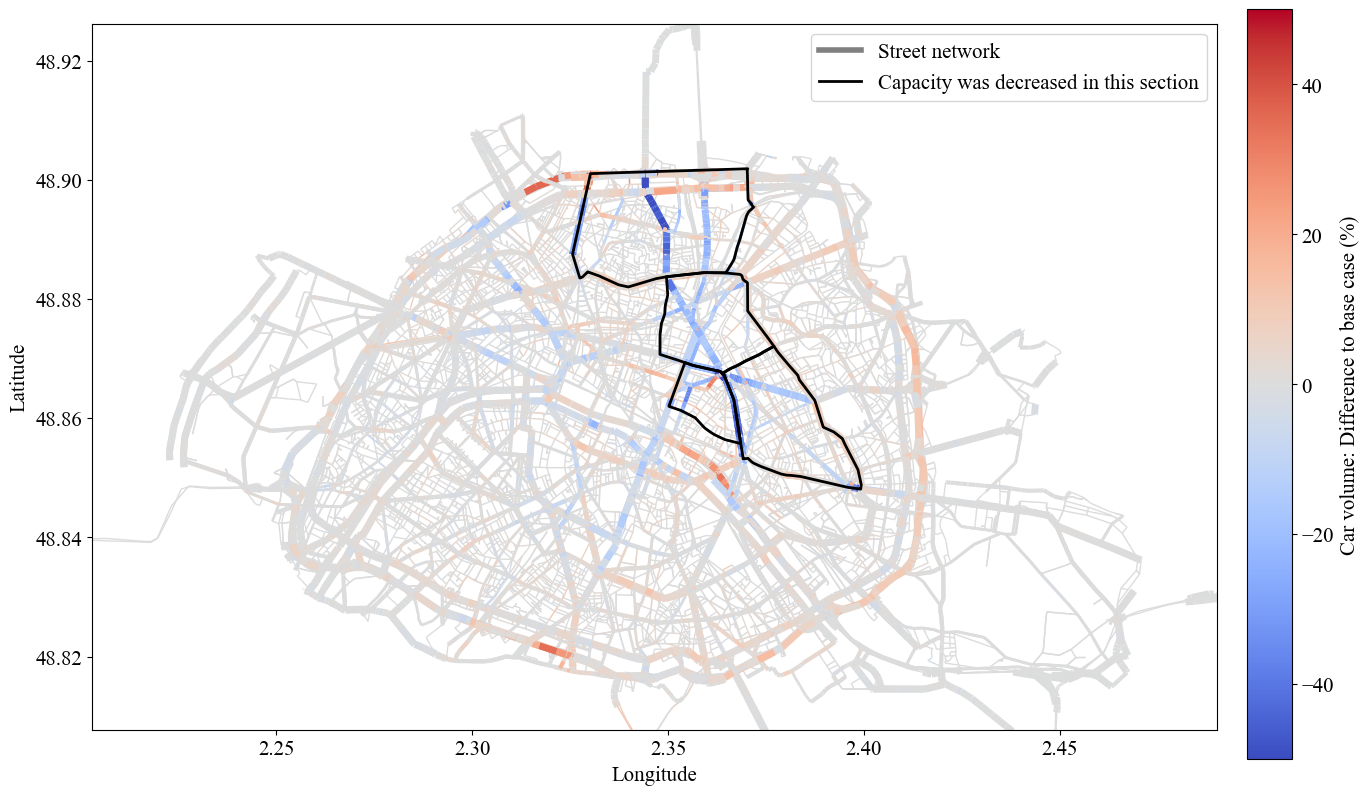

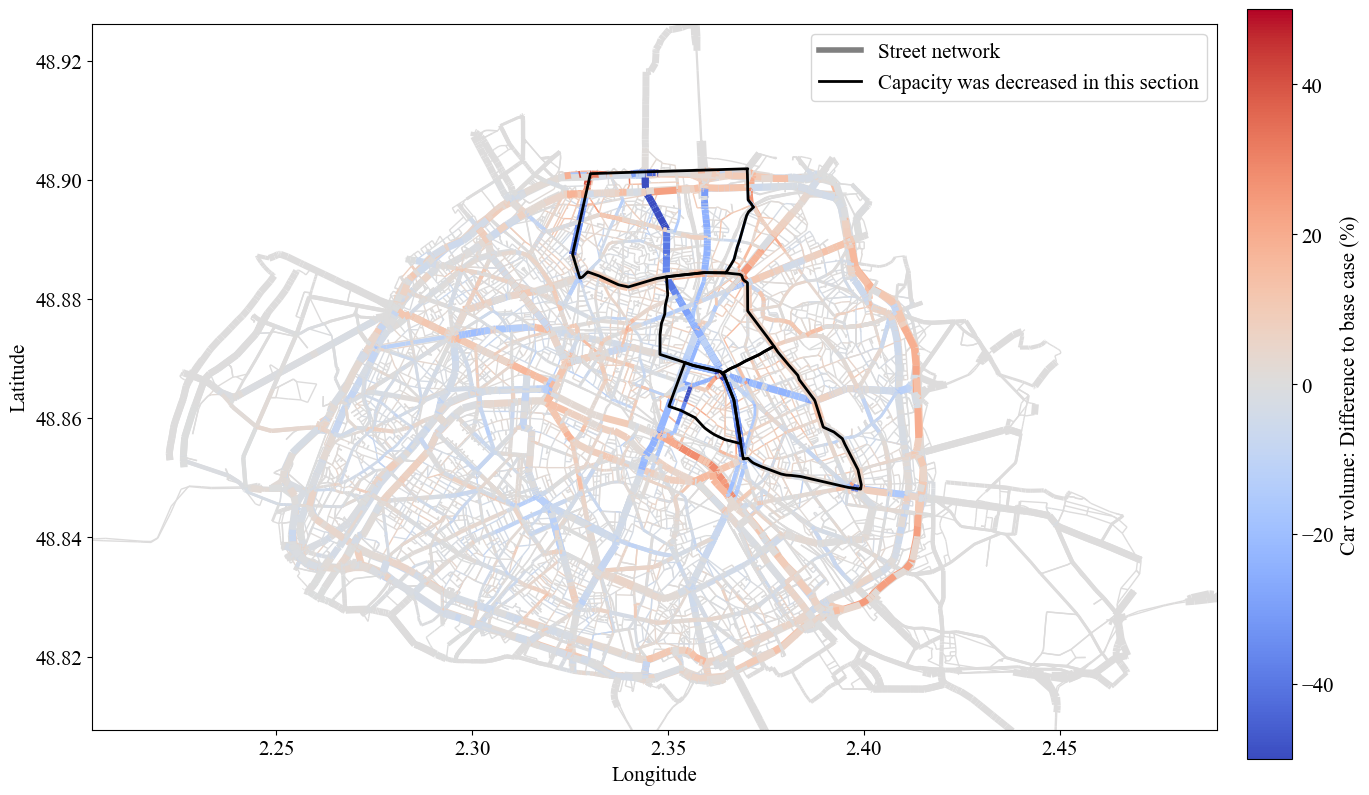

In [7]:
fixed_norm_max = 50

for i in range(50):
    # if i != 8:
    #     continue
    
    if i != 2:
    # and i != 12 and i != 16:
        continue
    my_test_data = test_set_loader.dataset[i]
    my_test_x = test_set_loader.dataset[i].x
    my_test_x = my_test_x.to('cpu')
    
    test_loss_my_test_data, r_squared_my_test_data, actual_vals_my_test_data, predictions_my_test_data, baseline_loss_my_test_data = hf.validate_model_on_test_set(model, my_test_data, loss_fct, device)
    print(f"Test {i}")
    print(f"Test Loss: {test_loss_my_test_data}")
    print(f"R-squared: {r_squared_my_test_data}")
    print(f"Baseline Loss: {baseline_loss_my_test_data}")

    inversed_x = scaler_x.inverse_transform(my_test_x)

    gdf_with_og_values = hf.data_to_geodataframe_with_og_values(data=my_test_data, original_gdf=links_base_case, predicted_values=predictions_my_test_data, inversed_x=inversed_x)
    gdf_with_og_values['capacity_reduction_rounded'] = gdf_with_og_values['capacity_reduction'].round(decimals=3)
    gdf_with_og_values['highway'] = gdf_with_og_values['highway'].map(hf.highway_mapping)
    # gdf_with_og_values['district'] = gdf_with_og_values.apply(
    # lambda row: districts[districts.contains(row.geometry)].iloc[0]['c_ar'] if not districts[districts.contains(row.geometry)].empty else 'Unknown',
    # axis=1
    gdf_with_og_values = gpd.sjoin(gdf_with_og_values, districts, how='left', op='intersects')

    hf.plot_combined_output(gdf_input=gdf_with_og_values, column_to_plot="vol_car_change_predicted", 
                            save_it=True, number_to_plot=i, zone_to_plot = "this zone", is_predicted=True, alpha=0, use_fixed_norm=True, 
                            fixed_norm_max = fixed_norm_max,
                            known_districts = False, buffer = 0.0005, districts_of_interest=None, plot_contour_lines=True, result_path=result_path)
    hf.plot_combined_output(gdf_input=gdf_with_og_values, column_to_plot="vol_car_change_actual", save_it=True, 
                            number_to_plot=i, zone_to_plot = "this zone",is_predicted=False,alpha=10,use_fixed_norm=True, 
                            fixed_norm_max = fixed_norm_max,
                            known_districts = False, buffer = 0.0005, districts_of_interest=None, plot_contour_lines=True, result_path=result_path)

In [8]:
# Generalize the creation of gdfs for a range of indices
gdfs = []
for i in range(len(test_set_loader.dataset)):
    my_test_data = test_set_loader.dataset[i]
    my_test_x = test_set_loader.dataset[i].x
    my_test_x = my_test_x.to('cpu')
    test_loss_my_test_data, r_squared_my_test_data, actual_vals_my_test_data, predictions_my_test_data, baseline_loss_my_test_data = hf.validate_model_on_test_set(model, my_test_data, loss_fct, device)
    inversed_x = scaler_x.inverse_transform(my_test_x)
    gdf = hf.data_to_geodataframe_with_og_values(data=my_test_data, original_gdf=links_base_case, predicted_values=predictions_my_test_data, inversed_x=inversed_x)
    gdf = gpd.sjoin(gdf, districts, how='left', op='intersects')
    gdf = gdf.rename(columns={"c_ar": "district"})
    gdf['capacity_reduction_rounded'] = gdf['capacity_reduction'].round(decimals=3)
    gdf['highway'] = gdf['highway'].map(hf.highway_mapping)
    gdfs.append(gdf)

/opt/anaconda3/envs/chenhao-gnn/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3493: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/opt/anaconda3/envs/chenhao-gnn/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3493: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/opt/anaconda3/envs/chenhao-gnn/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3493: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/opt/anaconda3/envs/chenhao-gnn/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3493: FutureWarning: The `op` parameter is de

/opt/anaconda3/envs/chenhao-gnn/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3493: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/opt/anaconda3/envs/chenhao-gnn/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3493: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/opt/anaconda3/envs/chenhao-gnn/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3493: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/opt/anaconda3/envs/chenhao-gnn/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3493: FutureWarning: The `op` parameter is de

In [9]:
# # Count district frequency in your scenarios
# district_counts = {}
# for gdf in gdfs:
#     # Get districts where capacity was reduced
#     districts_with_reduction = set(gdf[gdf['capacity_reduction_rounded'] < -1e-3]['district'].unique())
#     for district in districts_with_reduction:
#         district_counts[district] = district_counts.get(district, 0) + 1

# # Print district frequencies
# for district, count in sorted(district_counts.items(), key=lambda x: x[1], reverse=True):
#     print(f"District {district}: {count} times")

# # Check if all primary/secondary/tertiary roads in a district are consistently reduced
# for gdf in gdfs:
#     for district in gdf['district'].unique():
#         main_roads = gdf[(gdf['district'] == district) & 
#                         (gdf['highway'].isin([1,2,3]))]
#         reduced_roads = main_roads[main_roads['capacity_reduction_rounded'] < -1e-3]
#         if len(reduced_roads) > 0 and len(reduced_roads) != len(main_roads):
#             print(f"Inconsistent reduction in district {district}")

In [10]:
# Check average volumes by district
district_volumes = {}
for gdf in gdfs:
    for district in gdf['district'].unique():
        main_roads = gdf[(gdf['district'] == district) & 
                        (gdf['highway'].isin([1,2,3]))]
        avg_volume = main_roads['vol_base_case'].mean()
        district_volumes[district] = district_volumes.get(district, avg_volume)

# Print average volumes
for district, volume in sorted(district_volumes.items(), key=lambda x: x[1], reverse=True):
    print(f"District {district} average volume: {volume:.2f}")

District nan average volume: nan
District 4.0 average volume: 166.75
District 3.0 average volume: 140.38
District 8.0 average volume: 120.99
District 14.0 average volume: 118.21
District 17.0 average volume: 114.92
District 1.0 average volume: 104.82
District 2.0 average volume: 101.19
District 18.0 average volume: 100.53
District 10.0 average volume: 100.31
District 12.0 average volume: 89.48
District 9.0 average volume: 86.32
District 20.0 average volume: 84.96
District 19.0 average volume: 80.64
District 6.0 average volume: 72.47
District 5.0 average volume: 72.12
District 7.0 average volume: 64.60
District 11.0 average volume: 63.41
District 16.0 average volume: 63.33
District 13.0 average volume: 61.17
District 15.0 average volume: 61.01
District nan average volume: nan
District nan average volume: nan
District nan average volume: nan
District nan average volume: nan
District nan average volume: nan
District nan average volume: nan
District nan average volume: nan
District nan ave

/opt/anaconda3/envs/chenhao-gnn/lib/python3.10/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


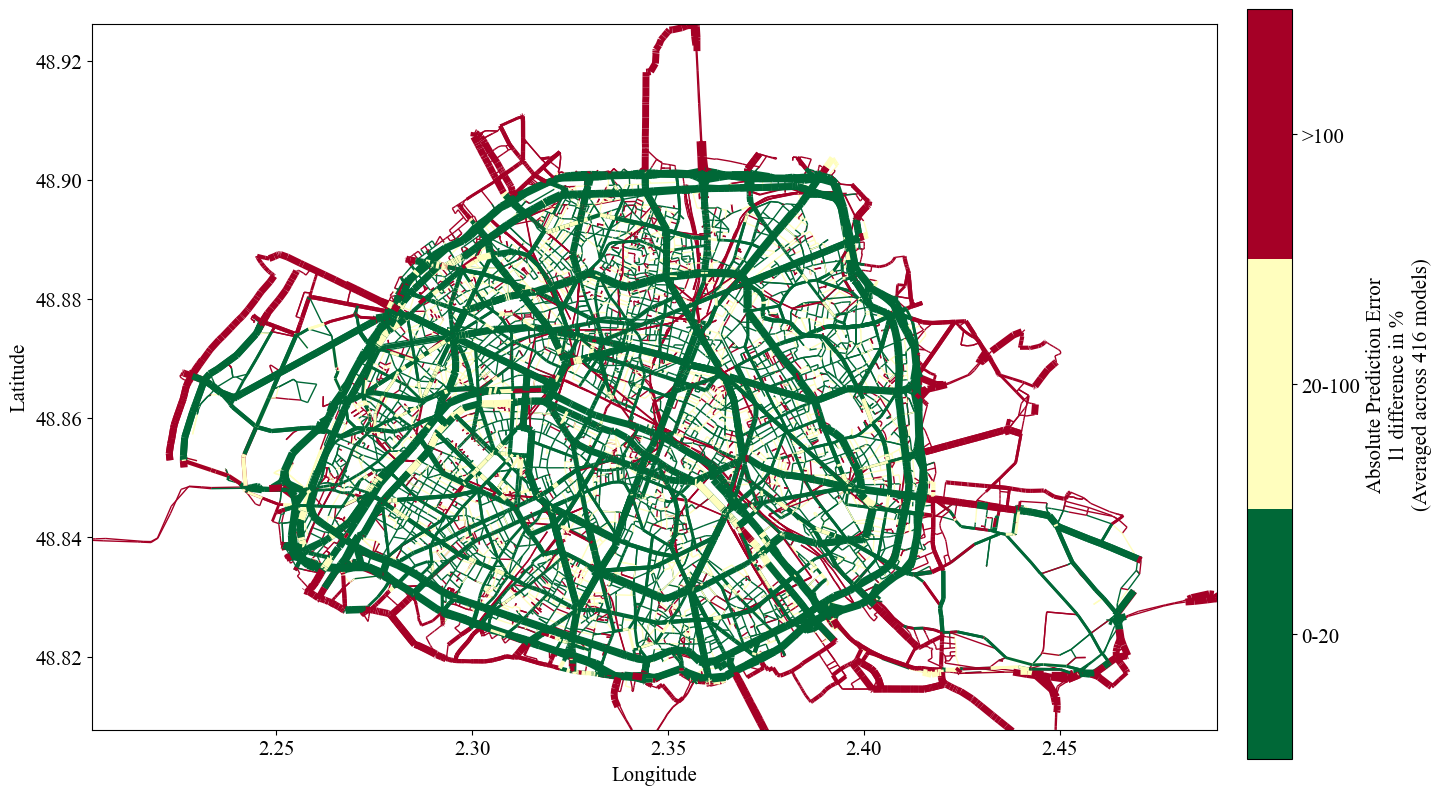

In [11]:
# For absolute differences in number of vehicles
result_gdf = hf.plot_average_prediction_differences(
    gdf_inputs=gdfs,
    scale_type="discrete",
    discrete_thresholds=(20, 100),
    save_it=True,
    use_fixed_norm=True,
    fixed_norm_max=100,
    use_absolute_value_of_difference=True,
    use_percentage=True,
    disagreement_threshold=None,
    result_path=result_path,
    loss_fct="l1"
)

In [12]:
len(gdfs)

416

In [13]:
# # For absolute differences in number of vehicles
# result_gdf = hf.plot_average_prediction_differences(
#     gdf_inputs=gdfs,
#     scale_type="discrete",
#     discrete_thresholds=(20, 40, 60, 80, 100),
#     save_it=True,
#     use_fixed_norm=True,
#     fixed_norm_max=100,
#     use_absolute_value_of_difference=True,
#     use_percentage=True,
#     disagreement_threshold=None,
#     result_path=result_path,
#     loss_fct="mse"
# )

In [14]:
# fixed_norm_max = 50

# for i in range(100):
#     if i != 14 and i != 21 and i != 33 and i != 38 and i != 39 and i != 45 and i != 58:
#         continue
#     my_test_data = test_set_loader.dataset[i]
#     my_test_x = test_set_loader.dataset[i].x
#     my_test_x = my_test_x.to('cpu')
    
#     test_loss_my_test_data, r_squared_my_test_data, actual_vals_my_test_data, predictions_my_test_data, baseline_loss_my_test_data = hf.validate_model_on_test_set(model, my_test_data, loss_fct, device)
#     print(f"Test {i}")
#     print(f"Test Loss: {test_loss_my_test_data}")
#     print(f"R-squared: {r_squared_my_test_data}")
#     print(f"Baseline Loss: {baseline_loss_my_test_data}")

#     inversed_x = scaler_x.inverse_transform(my_test_x)

#     gdf_with_og_values = hf.data_to_geodataframe_with_og_values(data=my_test_data, original_gdf=links_base_case, predicted_values=predictions_my_test_data, inversed_x=inversed_x)
#     gdf_with_og_values['capacity_reduction_rounded'] = gdf_with_og_values['capacity_reduction'].round(decimals=3)
#     gdf_with_og_values['highway'] = gdf_with_og_values['highway'].map(hf.highway_mapping)

#     hf.plot_combined_output(gdf_input=gdf_with_og_values, column_to_plot="vol_car_change_predicted", 
#                             save_it=True, number_to_plot=i, zone_to_plot = "this zone", is_predicted=True, alpha=0, use_fixed_norm=True, 
#                             fixed_norm_max = fixed_norm_max,
#                             known_districts = False, buffer = 0.0005, districts_of_interest=None, plot_contour_lines=True, result_path=result_path)
#     hf.plot_combined_output(gdf_input=gdf_with_og_values, column_to_plot="vol_car_change_actual", save_it=True, 
#                             number_to_plot=i, zone_to_plot = "this zone",is_predicted=False,alpha=10,use_fixed_norm=True, 
#                             fixed_norm_max = fixed_norm_max,
#                             known_districts = False, buffer = 0.0005, districts_of_interest=None, plot_contour_lines=True, result_path=result_path)

In [15]:
indices_roads_with_highway_primary_sec_tertiary = gdf_with_og_values[gdf_with_og_values['highway'].isin([1,2,3])].index
indices_roads_with_highway_primary_ = gdf_with_og_values[gdf_with_og_values['highway'].isin([1])].index
indices_roads_with_highway_sec = gdf_with_og_values[gdf_with_og_values['highway'].isin([2])].index
indices_roads_with_highway_tertiary = gdf_with_og_values[gdf_with_og_values['highway'].isin([3])].index
indices_roads_with_highway_not_primary_sec_tertiary = gdf_with_og_values[~gdf_with_og_values['highway'].isin([1, 2, 3])].index
indices_roads_with_highway_trunk = gdf_with_og_values[gdf_with_og_values['highway'].isin([0])].index
indices_roads_with_highway_residential_street = gdf_with_og_values[gdf_with_og_values['highway'].isin([4])].index
indices_roads_with_highway_living_street = gdf_with_og_values[gdf_with_og_values['highway'].isin([5])].index

# tolerance = 1e-3
# indices_roads_with_cap_reduction = gdf_with_og_values[gdf_with_og_values['capacity_reduction_rounded'] < -1e-3].index
# indices_roads_with_no_cap_reduction = gdf_with_og_values[gdf_with_og_values['capacity_reduction_rounded'] >= -1e-3].index

# indices_roads_with_highway_primary_sec_tertiary_and_cap_reduction = gdf_with_og_values[
#     (gdf_with_og_values['highway'].isin([1, 2, 3])) & 
#     (gdf_with_og_values['capacity_reduction_rounded'] < -1e-3)
# ].index
# indices_roads_with_highway_primary_sec_tertiary_and_not_cap_reduction = gdf_with_og_values[
#     (gdf_with_og_values['highway'].isin([1, 2, 3])) & 
#     (gdf_with_og_values['capacity_reduction_rounded'] >= -1e-3)
# ].index
# indices_roads_with_highway_primary_and_cap_reduction = gdf_with_og_values[
#     (gdf_with_og_values['highway'].isin([1])) & 
#     (gdf_with_og_values['capacity_reduction_rounded'] < -1e-3)
# ].index
# indices_roads_with_highway_primary_and_not_cap_reduction = gdf_with_og_values[
#     (gdf_with_og_values['highway'].isin([1])) & 
#     (gdf_with_og_values['capacity_reduction_rounded'] >= -1e-3)
# ].index
# indices_roads_with_highway_sec_and_cap_reduction = gdf_with_og_values[
#     (gdf_with_og_values['highway'].isin([2])) & 
#     (gdf_with_og_values['capacity_reduction_rounded'] < -1e-3)
# ].index
# indices_roads_with_highway_sec_and_not_cap_reduction = gdf_with_og_values[
#     (gdf_with_og_values['highway'].isin([2])) & 
#     (gdf_with_og_values['capacity_reduction_rounded'] >= -1e-3)
# ].index
# indices_roads_with_highway_tertiary_and_cap_reduction = gdf_with_og_values[
#     (gdf_with_og_values['highway'].isin([3])) & 
#     (gdf_with_og_values['capacity_reduction_rounded'] < -1e-3)
# ].index
# indices_roads_with_highway_tertiary_and_not_cap_reduction = gdf_with_og_values[
#     (gdf_with_og_values['highway'].isin([3])) & 
#     (gdf_with_og_values['capacity_reduction_rounded'] >= -1e-3)
# ].index


def compute_correlations_scipy(predictions, targets):
    """
    Compute correlations using scipy (for verification)
    """
    # pred_np = predictions.detach().cpu().numpy()
    # target_np = targets.detach().cpu().numpy()
    
    spearman_corr, _ = stats.spearmanr(predictions, targets)
    pearson_corr, _ = stats.pearsonr(predictions, targets)
    
    return spearman_corr, pearson_corr

In [16]:
# # Convert the GeoDataFrame to the appropriate coordinate reference system (CRS) for length calculation
# gdf_in_meters = gdf_with_og_values.to_crs("EPSG:32633")
# gdf_in_meters['length'] = gdf_in_meters.length
# total_length = gdf_in_meters['length'].sum() / 1000
# print(f"Total length of the street network: {total_length:.2f} km")
# gdf_with_reductions = gdf_in_meters.loc[indices_roads_with_cap_reduction]
# total_length_with_reductions = gdf_with_reductions['length'].sum() / 1000
# print(f"Total length of the street network with capacity reductions: {total_length_with_reductions:.2f} km")

In [17]:
# # Define road types and their corresponding indices
# road_types = {
#     "All Roads": gdf_with_og_values.index,
#     "Trunk Roads": indices_roads_with_highway_trunk,
#     "Primary Roads": indices_roads_with_highway_primary_,
#     "Secondary Roads": indices_roads_with_highway_sec,
#     "Tertiary Roads": indices_roads_with_highway_tertiary,
#     "Residential Streets": indices_roads_with_highway_residential_street,
#     "Living Streets": indices_roads_with_highway_living_street,
#     "Roads with Highway Primary, Secondary, or Tertiary": indices_roads_with_highway_primary_sec_tertiary,
#     # "Roads with Capacity Reduction": indices_roads_with_cap_reduction,
#     # "Roads with No Capacity Reduction": indices_roads_with_no_cap_reduction,
#     # "Roads with Highway Primary, Secondary, or Tertiary and Capacity Reduction": indices_roads_with_highway_primary_sec_tertiary_and_cap_reduction,
#     # "Roads with Highway Primary, Secondary, or Tertiary and No Capacity Reduction": indices_roads_with_highway_primary_sec_tertiary_and_not_cap_reduction,
#     # "Roads with Highway Primary and Capacity Reduction": indices_roads_with_highway_primary_and_cap_reduction,
#     # "Roads with Highway Primary and No Capacity Reduction": indices_roads_with_highway_primary_and_not_cap_reduction,
#     # "Roads with Highway Secondary and Capacity Reduction": indices_roads_with_highway_sec_and_cap_reduction,
#     # "Roads with Highway Secondary and No Capacity Reduction": indices_roads_with_highway_sec_and_not_cap_reduction,
#     # "Roads with Highway Tertiary and Capacity Reduction": indices_roads_with_highway_tertiary_and_cap_reduction,
#     # "Roads with Highway Tertiary and No Capacity Reduction": indices_roads_with_highway_tertiary_and_not_cap_reduction,   
# }

# def validate_model_for_one_observation(indices, gdf):
#     loss_fct_l1 = torch.nn.L1Loss()
#     loss_fct_l2 = torch.nn.MSELoss()
#     actual_vals = gdf.loc[indices, 'vol_car_change_actual']
#     predicted_vals = gdf.loc[indices, 'vol_car_change_predicted']
#     mean_car_vol = gdf.loc[indices, 'vol_base_case'].mean()
#     variance = gdf.loc[indices, 'variance'].mean()
#     std_dev = gdf.loc[indices, 'std_dev'].mean()
#     std_dev_multiplied = gdf.loc[indices, 'std_dev_multiplied'].mean()
#     cv_percent = gdf.loc[indices, 'cv_percent'].mean()
    
#     actual_vals = actual_vals.to_numpy()
#     predicted_vals = predicted_vals.to_numpy()
#     actual_mean = torch.mean(torch.tensor(actual_vals))
    
#     spearman_corr, pearson_corr = compute_correlations_scipy(predicted_vals, actual_vals)    
#     r_squared = hf.compute_r2_torch(preds=torch.tensor(predicted_vals), targets=torch.tensor(actual_vals))
    
#     l1_loss = loss_fct_l1(torch.tensor(actual_vals), torch.tensor(predicted_vals))
#     l2_loss = loss_fct_l2(torch.tensor(actual_vals), torch.tensor(predicted_vals))

#     l1_naive = loss_fct_l1(torch.tensor(actual_vals), torch.full_like(torch.tensor(actual_vals), actual_mean))    
#     l2_naive = loss_fct_l2(torch.tensor(actual_vals), torch.full_like(torch.tensor(actual_vals), actual_mean))
    
#     print(" ")
#     print(f"Road Type: {road_type}")
#     print(f"Number of observations: {len(indices)}")
#     print(f"Mean Car Volume: {mean_car_vol}")

#     print(f"R-squared: {round(r_squared.item(), 2)}")
#     print(f"MSE Loss: {l2_loss}")
#     print(f"Naive MSE Loss: {l2_naive}")
#     print(f"Variance: {variance}")

#     print(f"L1 Loss: {l1_loss}")
#     print(f"Naive L1 loss: {l1_naive}")
#     print(f"Standard Deviation Multiplied: {std_dev_multiplied}")

#     print(f"Spearman Correlation: {spearman_corr}")
#     print(f"Pearson Correlation: {pearson_corr}")
    
#     print(f"Standard Deviation: {std_dev}")
#     print(f"Coefficient of Variation: {cv_percent}")
#     print(" ")
    
#     return {
#         'road_type': road_type,
#         'number_of_observations': len(indices),
#         'mean_car_vol': mean_car_vol,
#         'r_squared': r_squared,
#         'mse': l2_loss,
#         'naive_mse': l2_naive,
#         'l1': l1_loss,
#         'naive_l1': l1_naive,
#         'variance': variance,
#         'std_dev': std_dev,
#         'std_dev_normalized': std_dev_multiplied,
#         'spearman': spearman_corr,
#         'pearson': pearson_corr,
#         'cv_percent': cv_percent
#     }

# # Collect metrics for each road type
# metrics_by_type = {}
# for road_type, indices in road_types.items():
#     metrics_by_type[road_type] = validate_model_for_one_observation(indices, gdf_with_og_values)

In [18]:
# Count district frequency in your scenarios
district_counts = {}
for gdf in gdfs:
    # Get districts where capacity was reduced
    districts_with_reduction = set(gdf[gdf['capacity_reduction_rounded'] < -1e-3]['district'].unique())
    for district in districts_with_reduction:
        district_counts[district] = district_counts.get(district, 0) + 1

# Print district frequencies
for district, count in sorted(district_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"District {district}: {count} times")

# Check if all primary/secondary/tertiary roads in a district are consistently reduced
for gdf in gdfs:
    for district in gdf['district'].unique():
        main_roads = gdf[(gdf['district'] == district) & 
                        (gdf['highway'].isin([1,2,3]))]
        reduced_roads = main_roads[main_roads['capacity_reduction_rounded'] < -1e-3]
        if len(reduced_roads) > 0 and len(reduced_roads) != len(main_roads):
            print(f"Inconsistent reduction in district {district}")

District 1.0: 386 times
District 10.0: 354 times
District 11.0: 347 times
District 5.0: 347 times
District 12.0: 341 times
District 6.0: 338 times
District 7.0: 334 times
District 15.0: 330 times
District 16.0: 329 times
District 8.0: 324 times
District 18.0: 321 times
District 14.0: 320 times
District 4.0: 311 times
District 9.0: 306 times
District 3.0: 296 times
District 19.0: 290 times
District 20.0: 280 times
District 17.0: 277 times
District 2.0: 269 times
District 13.0: 267 times
Inconsistent reduction in district 18.0
Inconsistent reduction in district 16.0
Inconsistent reduction in district 10.0
Inconsistent reduction in district 19.0
Inconsistent reduction in district 12.0
Inconsistent reduction in district 11.0
Inconsistent reduction in district 1.0
Inconsistent reduction in district 8.0
Inconsistent reduction in district 3.0
Inconsistent reduction in district 18.0
Inconsistent reduction in district 19.0
Inconsistent reduction in district 20.0
Inconsistent reduction in distri

Inconsistent reduction in district 5.0
Inconsistent reduction in district 16.0
Inconsistent reduction in district 10.0
Inconsistent reduction in district 7.0
Inconsistent reduction in district 20.0
Inconsistent reduction in district 14.0
Inconsistent reduction in district 11.0
Inconsistent reduction in district 4.0
Inconsistent reduction in district 2.0
Inconsistent reduction in district 1.0
Inconsistent reduction in district 6.0
Inconsistent reduction in district 5.0
Inconsistent reduction in district 18.0
Inconsistent reduction in district 16.0
Inconsistent reduction in district 10.0
Inconsistent reduction in district 19.0
Inconsistent reduction in district 7.0
Inconsistent reduction in district 13.0
Inconsistent reduction in district 11.0
Inconsistent reduction in district 4.0
Inconsistent reduction in district 2.0
Inconsistent reduction in district 1.0
Inconsistent reduction in district 8.0
Inconsistent reduction in district 6.0
Inconsistent reduction in district 5.0
Inconsistent r

In [19]:
def get_road_type_indices(gdf):
    """
    Get indices for different road types, including dynamic conditions like capacity reduction
    """
    tolerance = 1e-3
    indices = {
        # Static conditions (road types)
        "All Roads": gdf.index,
        "Trunk Roads": gdf[gdf['highway'].isin([0])].index,
        "Primary Roads": gdf[gdf['highway'].isin([1])].index,
        "Secondary Roads": gdf[gdf['highway'].isin([2])].index,
        "Tertiary Roads": gdf[gdf['highway'].isin([3])].index,
        "Residential Streets": gdf[gdf['highway'].isin([4])].index,
        "Living Streets": gdf[gdf['highway'].isin([5])].index,
        "Roads with Highway Primary, Secondary, or Tertiary": gdf[gdf['highway'].isin([1, 2, 3])].index,
        
        # Dynamic conditions (capacity reduction)
        # "Roads with Capacity Reduction": gdf[gdf['capacity_reduction_rounded'] < -tolerance].index,
        # "Roads with No Capacity Reduction": gdf[gdf['capacity_reduction_rounded'] >= -tolerance].index,
        
        # Combined conditions
        "Primary Roads with Capacity Reduction": gdf[
            (gdf['highway'].isin([1])) & 
            (gdf['capacity_reduction_rounded'] < -tolerance)
        ].index,
        "Primary Roads with No Capacity Reduction": gdf[
            (gdf['highway'].isin([1])) & 
            (gdf['capacity_reduction_rounded'] >= -tolerance)
        ].index,
        "Secondary Roads with Capacity Reduction": gdf[
            (gdf['highway'].isin([2])) & 
            (gdf['capacity_reduction_rounded'] < -tolerance)
        ].index,
        "Secondary Roads with No Capacity Reduction": gdf[
            (gdf['highway'].isin([2])) & 
            (gdf['capacity_reduction_rounded'] >= -tolerance)
        ].index,
        "Tertiary Roads with Capacity Reduction": gdf[
            (gdf['highway'].isin([3])) & 
            (gdf['capacity_reduction_rounded'] < -tolerance)
        ].index,    
        "Tertiary Roads with No Capacity Reduction": gdf[
            (gdf['highway'].isin([3])) & 
            (gdf['capacity_reduction_rounded'] >= -tolerance)
        ].index
    }
    return indices

def validate_model_with_interpretable_error(indices, gdfs):
    """
    Validate model performance across all test set observations for specific road types.
    
    Args:
        indices: Indices of roads to consider for each GDF
        gdfs: List of GeoDataFrames, each representing one test set observation
    """
    loss_fct_l1 = torch.nn.L1Loss()
    loss_fct_l2 = torch.nn.MSELoss()
    
    # Initialize lists to store values across all observations
    all_actual_vals = []
    all_predicted_vals = []
    mean_car_vols = []
    variances = []
    std_devs = []
    std_dev_multiplied = []
    cv_percents = []
    
    # Collect values from all GDFs
    for gdf in gdfs:
        indices = get_road_type_indices(gdf)[road_type]
        
        if len(indices) > 0:  # Only process if we have roads of this type
            actual_vals = gdf.loc[indices, 'vol_car_change_actual']
            predicted_vals = gdf.loc[indices, 'vol_car_change_predicted']
            
            all_actual_vals.extend(actual_vals.to_numpy())
            all_predicted_vals.extend(predicted_vals.to_numpy())
            
            # Collect statistics
            mean_car_vols.append(gdf.loc[indices, 'vol_base_case'].mean())
            variances.append(gdf.loc[indices, 'variance'].mean())
            std_devs.append(gdf.loc[indices, 'std_dev'].mean())
            std_dev_multiplied.append(gdf.loc[indices, 'std_dev_multiplied'].mean())
            cv_percents.append(gdf.loc[indices, 'cv_percent'].mean())
    
    # Convert to numpy arrays
    all_actual_vals = np.array(all_actual_vals)
    all_predicted_vals = np.array(all_predicted_vals)
    actual_mean = torch.mean(torch.tensor(all_actual_vals))
    
    # Calculate metrics
    spearman_corr, pearson_corr = compute_correlations_scipy(all_predicted_vals, all_actual_vals)    
    r_squared = hf.compute_r2_torch(preds=torch.tensor(all_predicted_vals), targets=torch.tensor(all_actual_vals))
    
    l1_loss = loss_fct_l1(torch.tensor(all_actual_vals), torch.tensor(all_predicted_vals))
    l2_loss = loss_fct_l2(torch.tensor(all_actual_vals), torch.tensor(all_predicted_vals))
    
    l1_naive = loss_fct_l1(torch.tensor(all_actual_vals), torch.full_like(torch.tensor(all_actual_vals), actual_mean))    
    l2_naive = loss_fct_l2(torch.tensor(all_actual_vals), torch.full_like(torch.tensor(all_actual_vals), actual_mean))
    
    # Calculate averages of statistics
    mean_car_vol = np.mean(mean_car_vols)
    variance = np.mean(variances)
    std_dev = np.mean(std_devs)
    std_dev_multiplied = np.mean(std_dev_multiplied)
    cv_percent = np.mean(cv_percents)
    
    print(" ")
    print(f"Road Type: {road_type}")
    print(f"Number of observations: {len(all_actual_vals)/416}")
    print(f"Mean Car Volume: {mean_car_vol}")
    print(f"R-squared: {round(r_squared.item(), 2)}")
    print(f"MSE Loss: {l2_loss}")
    print(f"Naive MSE Loss: {l2_naive}")
    print(f"Variance: {variance}")
    print(f"L1 Loss: {l1_loss}")
    print(f"Naive L1 loss: {l1_naive}")
    print(f"Standard Deviation Multiplied: {std_dev_multiplied}")
    print(f"Spearman Correlation: {spearman_corr}")
    print(f"Pearson Correlation: {pearson_corr}")
    print(f"Standard Deviation: {std_dev}")
    print(f"Coefficient of Variation: {cv_percent}")
    print(" ")
    
    return {
        'road_type': road_type,
        'number_of_observations': len(all_actual_vals),
        'mean_car_vol': mean_car_vol,
        'r_squared': r_squared,
        'mse': l2_loss,
        'naive_mse': l2_naive,
        'l1': l1_loss,
        'naive_l1': l1_naive,
        'variance': variance,
        'std_dev': std_dev,
        'std_dev_normalized': std_dev_multiplied,
        'spearman': spearman_corr,
        'pearson': pearson_corr,
        'cv_percent': cv_percent
    }

road_types = list(get_road_type_indices(gdfs[0]).keys())

# Then calculate metrics for each road type
metrics_by_type = {}
for road_type in road_types:
    metrics_by_type[road_type] = validate_model_with_interpretable_error(road_type, gdfs)

 
Road Type: All Roads
Number of observations: 35160.0
Mean Car Volume: 52.21265101034725
R-squared: 0.74
MSE Loss: 23.3508358001709
Naive MSE Loss: 88.32208251953125
Variance: 8.878591835668585
L1 Loss: 2.6531426906585693
Naive L1 loss: 3.6264116764068604
Standard Deviation Multiplied: 1.7048792843553287
Spearman Correlation: 0.43829125166759625
Pearson Correlation: 0.8582438310111948
Standard Deviation: 2.136749309498867
Coefficient of Variation: 18.65689505679291
 
 
Road Type: Trunk Roads
Number of observations: 1011.0
Mean Car Volume: 505.1565870660825
R-squared: 0.51
MSE Loss: 85.78178405761719
Naive MSE Loss: 173.36642456054688
Variance: 18.8704638398689
L1 Loss: 5.684872627258301
Naive L1 loss: 7.673269748687744
Standard Deviation Multiplied: 2.94609567412481
Spearman Correlation: 0.5273701145696188
Pearson Correlation: 0.7131065794689859
Standard Deviation: 3.6923833582646632
Coefficient of Variation: 5.494923339351302
 
 
Road Type: Primary Roads
Number of observations: 6112.

In [20]:
asdfa

NameError: name 'asdfa' is not defined

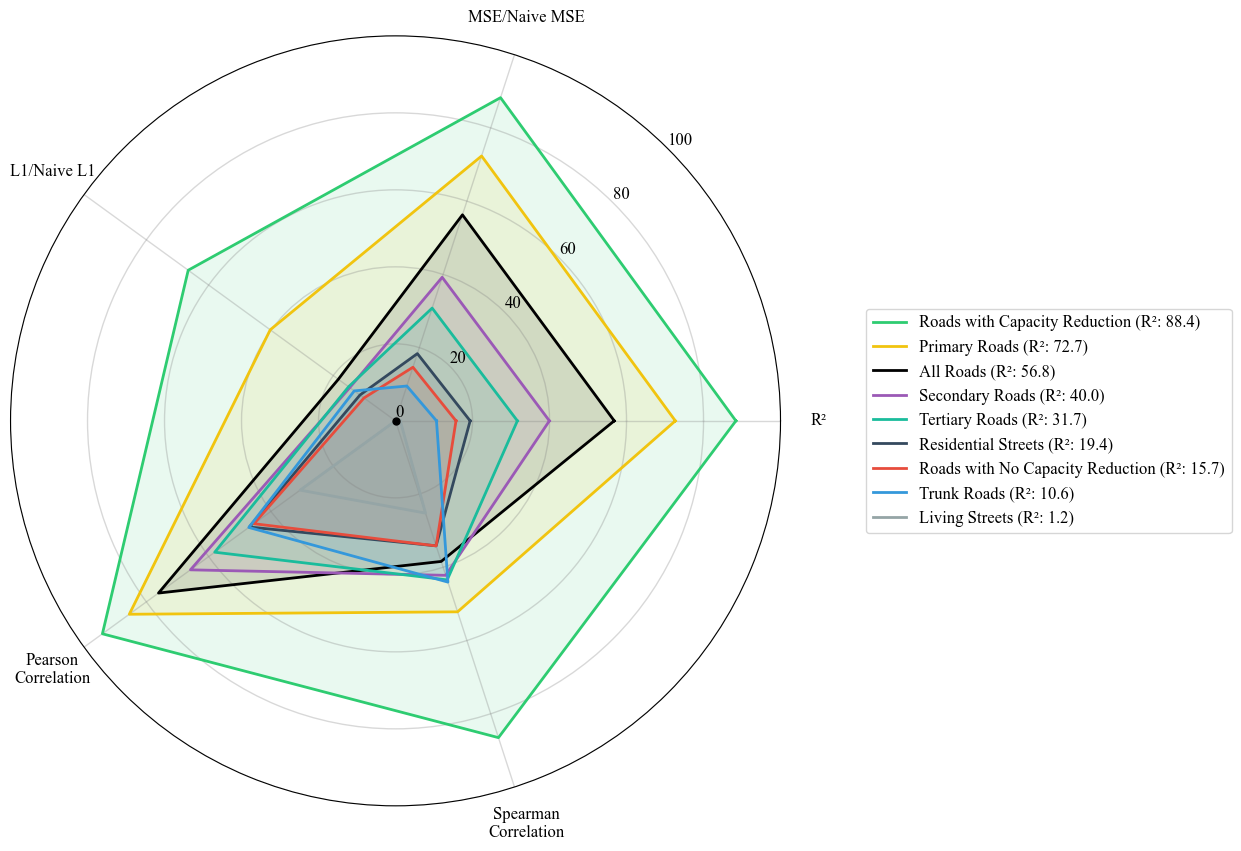

In [13]:
def create_correlation_radar_plot(metrics_by_type, selected_metrics=None):

    """
    Create a radar plot for model performance metrics.
    
    Args:
        metrics_by_type (dict): Dictionary containing metrics for each road type
        selected_metrics (list, optional): List of metrics to display. Each metric should be a dict with:
            - 'id': identifier in metrics_by_type
            - 'label': display label
            - 'transform': function to transform the value (or None to use directly)
            - 'y_pos': y-position of the label
    """
    # Default metrics if none specified
    if selected_metrics is None:
        selected_metrics = [
            {
                'id': 'r_squared',
                'label': 'R²',
                'transform': lambda x: max(0, x * 100),
                'y_pos': -0.05
            },
            {
                'id': 'mse_ratio',
                'label': 'MSE/Naive MSE',
                'transform': lambda x, max_ratio: (1 - x/max_ratio) * 100,
                'y_pos': -0.1
            },
            {
                'id': 'pearson',
                'label': 'Pearson\nCorrelation',
                'transform': lambda x: max(0, x * 100),
                'y_pos': -0.05
            },
            {
                'id': 'spearman',
                'label': 'Spearman\nCorrelation',
                'transform': lambda x: max(0, x * 100),
                'y_pos': -0.05
            }
        ]
    
    # Select specific road types
    selected_types = [
        'All Roads',
        'Trunk Roads',
        'Primary Roads',
        'Secondary Roads',
        'Tertiary Roads',
        'Residential Streets',
        'Living Streets',
        'Roads with Capacity Reduction',
        'Roads with No Capacity Reduction'
    ]
    
    filtered_metrics = {rt: metrics_by_type[rt] for rt in selected_types}
    road_types = sorted(filtered_metrics.keys(), 
                       key=lambda x: filtered_metrics[x]['r_squared'],
                       reverse=True)
    
    # Calculate maximum ratios for normalization if needed
    max_ratios = {}
    for metric in selected_metrics:
        if 'ratio' in metric['id']:
            if metric['id'] == 'mse_ratio':
                max_ratios['mse'] = max(metrics_by_type[rt]['mse'] / 
                                      metrics_by_type[rt]['naive_mse'] 
                                      for rt in road_types)
            elif metric['id'] == 'l1_ratio':
                max_ratios['l1'] = max(metrics_by_type[rt]['l1'] / 
                                     metrics_by_type[rt]['naive_l1'] 
                                     for rt in road_types)
    
    # Setup plot
    num_vars = len(selected_metrics)
    angles = [n / float(num_vars) * 2 * np.pi for n in range(num_vars)]
    angles += angles[:1]
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    ax.grid(True, color='gray', alpha=0.3)
    
    # Color palette
    colors = {
        'All Roads': '#000000',
        'Roads with Capacity Reduction': '#2ecc71',
        'Roads with No Capacity Reduction': '#e74c3c',
        'Trunk Roads': '#3498db',
        'Primary Roads': '#f1c40f',
        'Secondary Roads': '#9b59b6',
        'Tertiary Roads': '#1abc9c',
        'Residential Streets': '#34495e',
        'Living Streets': '#95a5a6'
    }
    
    # Plot data
    for road_type in road_types:
        values = []
        for metric in selected_metrics:
            if 'ratio' in metric['id']:
                if metric['id'] == 'mse_ratio':
                    ratio = filtered_metrics[road_type]['mse'] / filtered_metrics[road_type]['naive_mse']
                    values.append(metric['transform'](ratio, max_ratios['mse']))
                elif metric['id'] == 'l1_ratio':
                    ratio = filtered_metrics[road_type]['l1'] / filtered_metrics[road_type]['naive_l1']
                    values.append(metric['transform'](ratio, max_ratios['l1']))
            else:
                val = filtered_metrics[road_type][metric['id']]
                values.append(metric['transform'](val))
        values += values[:1]
        
        ax.plot(angles, values, linewidth=2, linestyle='solid',
                label=f"{road_type} (R²: {filtered_metrics[road_type]['r_squared']*100:.1f})",
                color=colors[road_type])
        ax.fill(angles, values, alpha=0.1, color=colors[road_type])

    # Set chart properties
    ax.set_xticks(angles[:-1])
    
    # Set the labels with proper positioning
    ax.set_xticklabels(
        [m['label'] for m in selected_metrics],
        fontsize=12,
        y=-0.05  # Move labels outward
    )
    
    ax.set_ylim(0, 100)
    ax.set_rgrids([0, 20, 40, 60, 80, 100], angle=45, fontsize=12)
    
    # Grid lines
    for line in ax.yaxis.get_gridlines() + ax.xaxis.get_gridlines():
        line.set_color('gray')
        line.set_linewidth(1.0)
        line.set_alpha(0.3)
    
    # Center point and circle
    ax.plot(0, 0, 'k.', markersize=10)
    circle = plt.Circle((0, 0), 1, fill=False, color='gray', linewidth=1.0, alpha=0.5)
    ax.add_artist(circle)
    
    # Legend
    ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), fontsize=12)
    
    # plt.title("Model Performance Metrics by Road Type\n(Higher values indicate better performance)",
    #           pad=20, fontsize=14)
    
    plt.savefig("correlation_radar_plot.png", bbox_inches='tight', dpi=300)
    plt.show()
    
# Use default metrics (R², MSE/Naive MSE, Pearson, Spearman)
# create_correlation_radar_plot(metrics_by_type)

# Use custom metrics
custom_metrics_3 = [
    {
        'id': 'r_squared',
        'label': 'R²',
        'transform': lambda x: max(0, x * 100),
        'y_pos': -0.05
    },
    {
        'id': 'pearson',
        'label': 'Pearson\nCorrelation',
        'transform': lambda x: max(0, x * 100),
        'y_pos': -0.05
    },
    {
        'id': 'spearman',
        'label': 'Spearman\nCorrelation',
        'transform': lambda x: max(0, x * 100),
        'y_pos': -0.05
    }
]

selected_metrics_5 = [
            {
                'id': 'r_squared',
                'label': 'R²',
                'transform': lambda x: max(0, x * 100),
                'y_pos': -0.05
            },
            {
                'id': 'mse_ratio',
                'label': 'MSE/Naive MSE',
                'transform': lambda x, max_ratio: (1 - x/max_ratio) * 100,
                'y_pos': -0.1
            },
            {
                'id': 'l1_ratio',
                'label': 'L1/Naive L1',
                'transform': lambda x, max_ratio: (1 - x/max_ratio) * 100,
                'y_pos': -0.1
            },
            {
                'id': 'pearson',
                'label': 'Pearson\nCorrelation',
                'transform': lambda x: max(0, x * 100),
                'y_pos': -0.05
            },
            {
                'id': 'spearman',
                'label': 'Spearman\nCorrelation',
                'transform': lambda x: max(0, x * 100),
                'y_pos': -0.05
            }
        ]
create_correlation_radar_plot(metrics_by_type, selected_metrics_5)

Pearson Correlation MSE vs CV:  0.13745733310429475
Pearson Correlation L1 vs CV:  0.37405865285834544


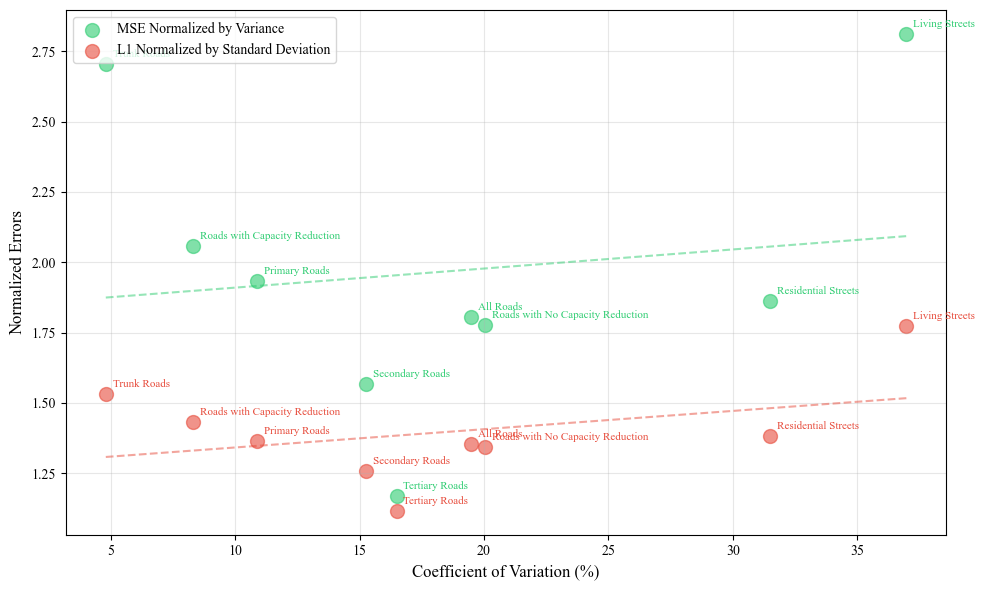

In [31]:
def create_error_vs_cv_plot(metrics_by_type):
    """
    Create a scatter plot comparing error ratios with coefficient of variation across road types.
    """
    plt.rcParams["font.family"] = "Times New Roman"
    
    # Define selected road types
    selected_types = [
        'All Roads',
        'Trunk Roads',
        'Primary Roads',
        'Secondary Roads',
        'Tertiary Roads',
        'Residential Streets',
        'Living Streets',
        'Roads with Capacity Reduction',
        'Roads with No Capacity Reduction'
    ]
    
    # Filter metrics for selected types
    filtered_metrics = {rt: metrics_by_type[rt] for rt in selected_types}
    
    # Prepare data
    cv_values = [filtered_metrics[rt]['cv_percent'] for rt in selected_types]
    # mse_var_ratio = [(filtered_metrics[rt]['mse'] - filtered_metrics[rt]['variance'])/filtered_metrics[rt]['variance'] for rt in selected_types]
    # l1_std_ratio = [(filtered_metrics[rt]['l1'] - filtered_metrics[rt]['std_dev_normalized'])/filtered_metrics[rt]['std_dev_normalized'] for rt in selected_types]
    
    mse_var_ratio = [(filtered_metrics[rt]['mse']/filtered_metrics[rt]['variance']) for rt in selected_types]
    l1_std_ratio = [(filtered_metrics[rt]['l1']/filtered_metrics[rt]['std_dev_normalized']) for rt in selected_types]
    # mse_var_ratio = [(filtered_metrics[rt]['mse'] - filtered_metrics[rt]['naive_mse'])/filtered_metrics[rt]['variance'] for rt in selected_types]
    # l1_std_ratio = [(filtered_metrics[rt]['l1'] - filtered_metrics[rt]['std_dev'])/filtered_metrics[rt]['std_dev'] for rt in selected_types]
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot both relationships
    scatter1 = ax.scatter(cv_values, mse_var_ratio, c='#2ecc71', s=100, alpha=0.6, label='MSE Normalized by Variance')    
    scatter2 = ax.scatter(cv_values, l1_std_ratio, c='#e74c3c', s=100, alpha=0.6, label='L1 Normalized by Standard Deviation')
    
    # Add labels for each point
    for i, road_type in enumerate(selected_types):
        ax.annotate(road_type, 
                   (cv_values[i], mse_var_ratio[i]),
                   xytext=(5, 5), textcoords='offset points',
                   fontsize=8, color='#2ecc71')
        ax.annotate(road_type, 
                   (cv_values[i], l1_std_ratio[i]),
                   xytext=(5, 5), textcoords='offset points',
                   fontsize=8, color='#e74c3c')
    
    # Calculate and plot trend lines
    z1 = np.polyfit(cv_values, mse_var_ratio, 1)
    p1 = np.poly1d(z1)
    z2 = np.polyfit(cv_values, l1_std_ratio, 1)
    p2 = np.poly1d(z2)
    
    x_trend = np.linspace(min(cv_values), max(cv_values), 100)
    ax.plot(x_trend, p1(x_trend), '--', color='#2ecc71', alpha=0.5)
    ax.plot(x_trend, p2(x_trend), '--', color='#e74c3c', alpha=0.5)
    
    # Calculate correlations
    pearson_mse_cv = stats.pearsonr(cv_values, mse_var_ratio)[0]
    pearson_l1_cv = stats.pearsonr(cv_values, l1_std_ratio)[0]
    
    ax.legend()
    # Add correlation coefficients to legend
    # ax.legend(title=f'Pearson Correlations: Normalized MSE vs CV: {pearson_mse_cv:.2f}, Normalized L1 vs CV: {pearson_l1_cv:.2f}')
    
    # Customize plot
    ax.set_xlabel('Coefficient of Variation (%)', fontsize=12)
    ax.set_ylabel('Normalized Errors', fontsize=12)
    # ax.set_ylabel('Error/Variability Ratio', fontsize=12)
    # ax.set_title('Relationship between Error Ratios and Traffic Variability\nby Road Type', 
    #              fontsize=14, pad=20)
    
    ax.grid(True, alpha=0.3)
    
    print("Pearson Correlation MSE vs CV: ", pearson_mse_cv)
    print("Pearson Correlation L1 vs CV: ", pearson_l1_cv)
    
    plt.tight_layout()
    plt.savefig("error_vs_cv_plot.png", bbox_inches='tight', dpi=300)
    plt.show()

# Use the function
create_error_vs_cv_plot(metrics_by_type)

In [17]:
def create_error_ratio_tables(metrics_by_type):
    """
    Create two tables comparing error metrics with their respective variability measures.
    """
    # Define selected road types
    selected_types = [
        'All Roads',
        'Trunk Roads',
        'Primary Roads',
        'Secondary Roads',
        'Tertiary Roads',
        'Residential Streets',
        'Living Streets',
        'Roads with Capacity Reduction',
        'Roads with No Capacity Reduction'
    ]
    
    # Create DataFrames for both tables
    # Table A: MSE related metrics
    mse_data = {
        'Road Type': selected_types,
        'MSE': [metrics_by_type[rt]['mse'] for rt in selected_types],
        'Variance': [metrics_by_type[rt]['variance'] for rt in selected_types],
        'MSE/Variance': [metrics_by_type[rt]['mse']/metrics_by_type[rt]['variance'] 
                        for rt in selected_types],
        'CV (%)': [metrics_by_type[rt]['cv_percent'] for rt in selected_types]
    }
    
    # Table B: L1 related metrics
    l1_data = {
        'Road Type': selected_types,
        'L1': [metrics_by_type[rt]['l1'] for rt in selected_types],
        'Norm. Std Dev': [metrics_by_type[rt]['std_dev_normalized'] for rt in selected_types],
        'L1/Norm. Std Dev': [metrics_by_type[rt]['l1']/metrics_by_type[rt]['std_dev_normalized'] 
                            for rt in selected_types],
        'CV (%)': [metrics_by_type[rt]['cv_percent'] for rt in selected_types]
    }
    
    # Create DataFrames
    df_mse = pd.DataFrame(mse_data)
    df_l1 = pd.DataFrame(l1_data)
    
    # Round numbers for better readability
    df_mse['MSE'] = df_mse['MSE'].round(2)
    df_mse['Variance'] = df_mse['Variance'].round(2)
    df_mse['MSE/Variance'] = df_mse['MSE/Variance'].round(2)
    df_mse['CV (%)'] = df_mse['CV (%)'].round(1)
    
    df_l1['L1'] = df_l1['L1'].round(2)
    df_l1['Norm. Std Dev'] = df_l1['Norm. Std Dev'].round(2)
    df_l1['L1/Norm. Std Dev'] = df_l1['L1/Norm. Std Dev'].round(2)
    df_l1['CV (%)'] = df_l1['CV (%)'].round(1)
    
    # Convert to LaTeX
    latex_mse = df_mse.to_latex(index=False, escape=False)
    latex_l1 = df_l1.to_latex(index=False, escape=False)
    
    print("Table A: MSE and Variance Metrics")
    print(df_mse)
    print("\nTable B: L1 and Normalized Standard Deviation Metrics")
    print(df_l1)
    print("\nLaTeX for Table A:")
    print(latex_mse)
    print("\nLaTeX for Table B:")
    print(latex_l1)
    
    return df_mse, df_l1

# Create the tables
df_mse, df_l1 = create_error_ratio_tables(metrics_by_type)

Table A: MSE and Variance Metrics
                          Road Type              MSE  Variance  \
0                         All Roads  tensor(15.4889)      8.57   
1                       Trunk Roads  tensor(49.5455)     18.32   
2                     Primary Roads  tensor(37.1678)     19.22   
3                   Secondary Roads  tensor(19.9437)     12.72   
4                    Tertiary Roads  tensor(12.5615)     10.75   
5               Residential Streets   tensor(8.0666)      4.33   
6                    Living Streets   tensor(3.4524)      1.23   
7     Roads with Capacity Reduction  tensor(40.6260)     19.75   
8  Roads with No Capacity Reduction  tensor(14.2543)      8.02   

     MSE/Variance  CV (%)  
0  tensor(1.8073)    19.5  
1  tensor(2.7040)     4.8  
2  tensor(1.9342)    10.9  
3  tensor(1.5681)    15.2  
4  tensor(1.1686)    16.5  
5  tensor(1.8619)    31.5  
6  tensor(2.8122)    37.0  
7  tensor(2.0567)     8.3  
8  tensor(1.7771)    20.0  

Table B: L1 and Normaliz

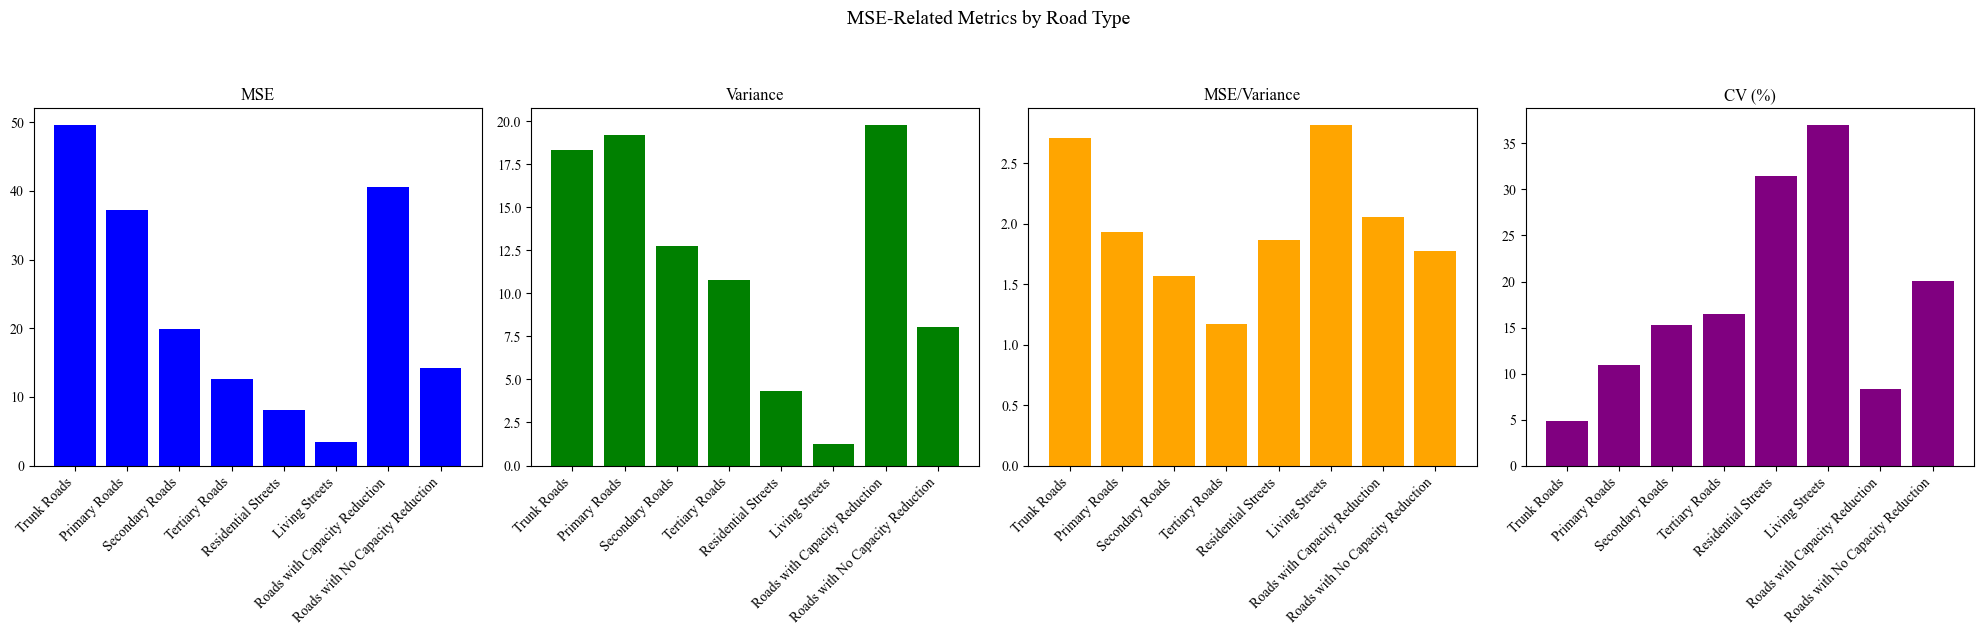

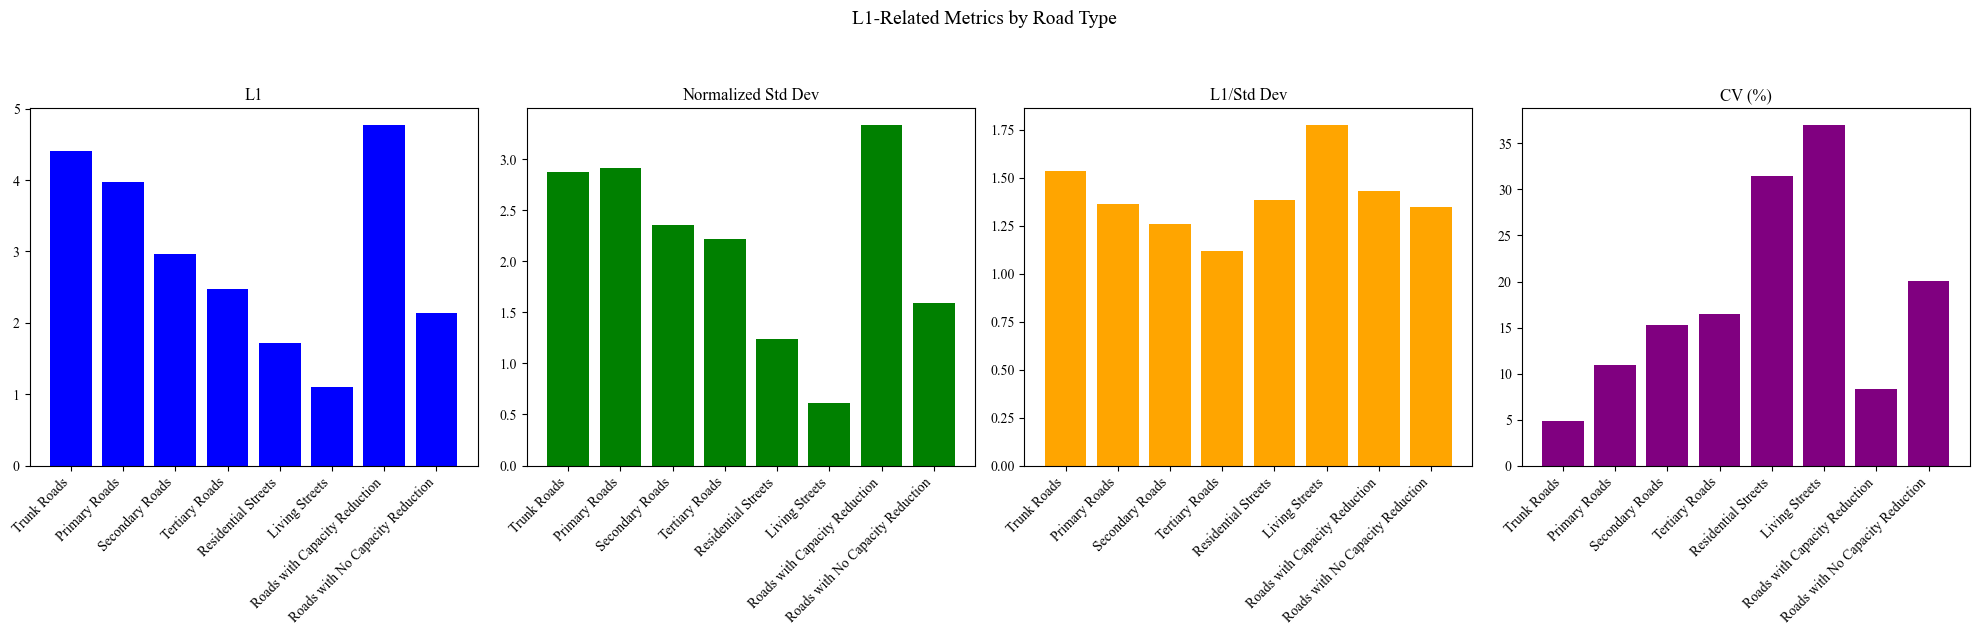

In [33]:
def create_error_ratio_barplots(metrics_by_type):
    """
    Create bar plots comparing error metrics with their respective variability measures.
    """
    plt.rcParams["font.family"] = "Times New Roman"
    
    # Define selected road types
    selected_types = [
        # 'All Roads',
        'Trunk Roads',
        'Primary Roads',
        'Secondary Roads',
        'Tertiary Roads',
        'Residential Streets',
        'Living Streets',
        'Roads with Capacity Reduction',
        'Roads with No Capacity Reduction'
    ]
    
    # Prepare data
    x = np.arange(len(selected_types))
    bar_width = 0.2

    # Plot 1: MSE-related metrics
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 6))
    fig.suptitle('MSE-Related Metrics by Road Type', fontsize=14, y=1.05)
    
    # MSE
    ax1.bar(x, [metrics_by_type[rt]['mse'] for rt in selected_types], color='blue')
    ax1.set_title('MSE')
    ax1.set_xticks(x)
    ax1.set_xticklabels(selected_types, rotation=45, ha='right')
    
    # Variance
    ax2.bar(x, [metrics_by_type[rt]['variance'] for rt in selected_types], color='green')
    ax2.set_title('Variance')
    ax2.set_xticks(x)
    ax2.set_xticklabels(selected_types, rotation=45, ha='right')
    
    # MSE/Variance
    mse_var_ratio = [(metrics_by_type[rt]['mse'])/metrics_by_type[rt]['variance'] for rt in selected_types]
    ax3.bar(x, mse_var_ratio, color='orange')
    ax3.set_title('MSE/Variance')
    ax3.set_xticks(x)
    ax3.set_xticklabels(selected_types, rotation=45, ha='right')
    
    # CV
    ax4.bar(x, [metrics_by_type[rt]['cv_percent'] for rt in selected_types], color='purple')
    ax4.set_title('CV (%)')
    ax4.set_xticks(x)
    ax4.set_xticklabels(selected_types, rotation=45, ha='right')
    
    plt.tight_layout()
    plt.savefig("mse_metrics.png", bbox_inches='tight', dpi=300)
    plt.show()

    # Plot 2: L1-related metrics
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 6))
    fig.suptitle('L1-Related Metrics by Road Type', fontsize=14, y=1.05)
    
    # L1
    ax1.bar(x, [metrics_by_type[rt]['l1'] for rt in selected_types], color='blue')
    ax1.set_title('L1')
    ax1.set_xticks(x)
    ax1.set_xticklabels(selected_types, rotation=45, ha='right')
    
    # Normalized Std Dev
    ax2.bar(x, [metrics_by_type[rt]['std_dev_normalized'] for rt in selected_types], color='green')
    ax2.set_title('Normalized Std Dev')
    ax2.set_xticks(x)
    ax2.set_xticklabels(selected_types, rotation=45, ha='right')
    
    # L1/Normalized Std Dev
    l1_std_ratio = [(metrics_by_type[rt]['l1'])/metrics_by_type[rt]['std_dev_normalized'] for rt in selected_types]
    ax3.bar(x, l1_std_ratio, color='orange')
    ax3.set_title('L1/Std Dev')
    ax3.set_xticks(x)
    ax3.set_xticklabels(selected_types, rotation=45, ha='right')
    
    # CV
    ax4.bar(x, [metrics_by_type[rt]['cv_percent'] for rt in selected_types], color='purple')
    ax4.set_title('CV (%)')
    ax4.set_xticks(x)
    ax4.set_xticklabels(selected_types, rotation=45, ha='right')
    
    plt.tight_layout()
    plt.savefig("l1_metrics.png", bbox_inches='tight', dpi=300)
    plt.show()

# Create the plots
create_error_ratio_barplots(metrics_by_type)



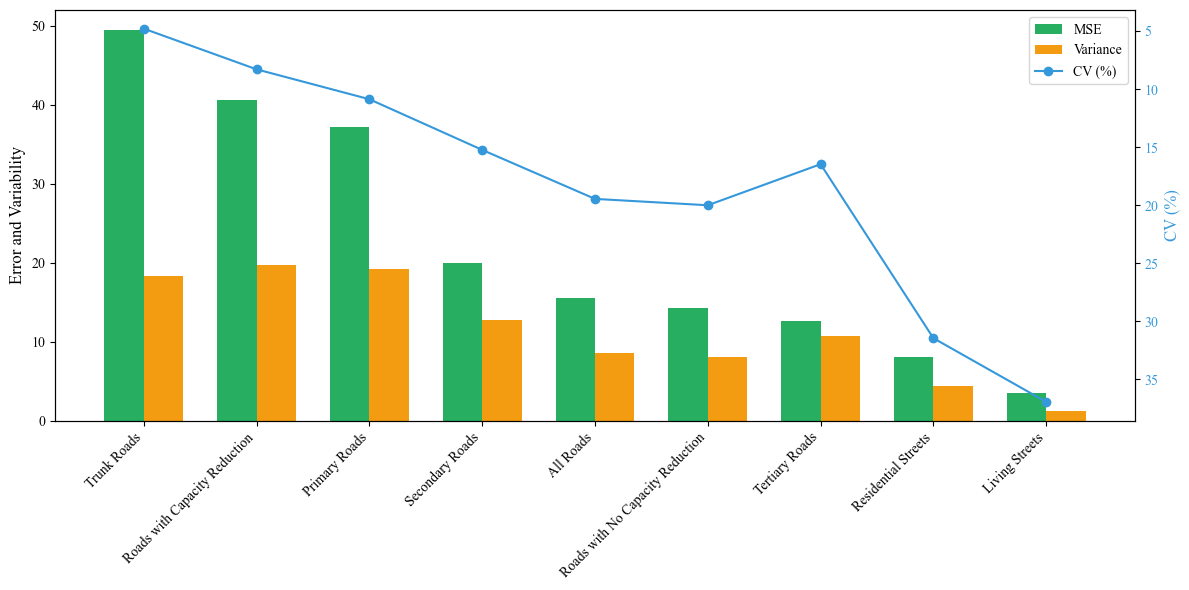

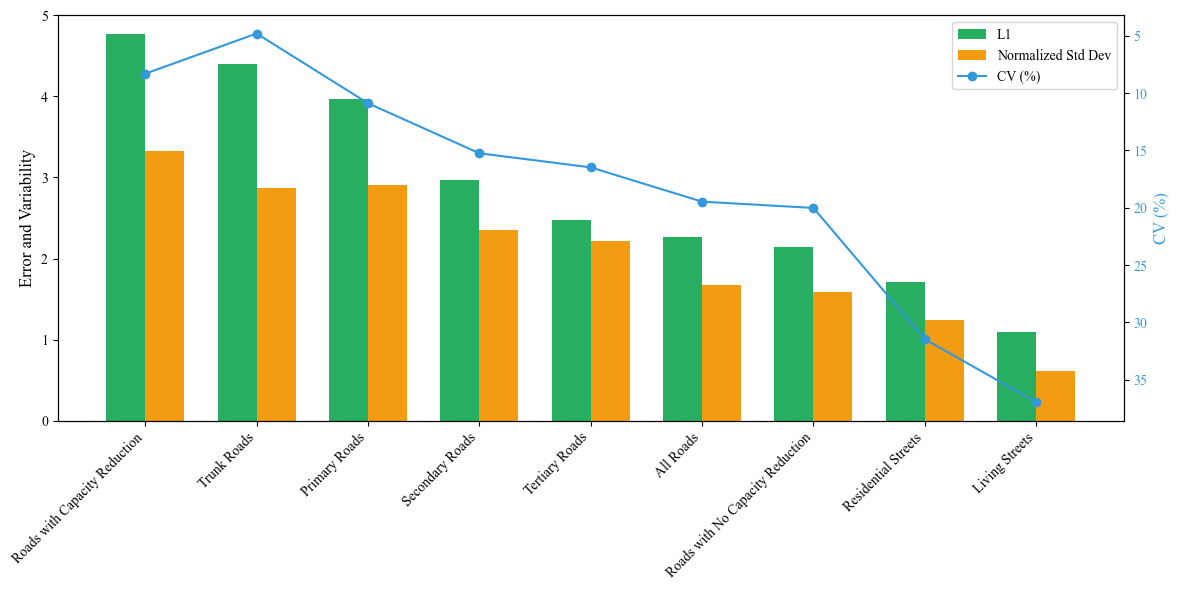

Correlations for MSE vs Variance plot:
Pearson r (MSE vs CV) = -0.36
Pearson r (Variance vs CV) = -0.30
Pearson r (MSE vs Variance) = 0.94

Correlations for L1 vs Normalized Std Dev plot:
Pearson r (L1 vs CV) = -0.37
Pearson r (Norm Std Dev vs CV) = -0.34
Pearson r (L1 vs Norm Std Dev) = 0.97


In [49]:
def create_error_ratio_plots(metrics_by_type):
    """
    Create two separate plots: one for MSE vs Variance and one for L1 vs Normalized Std Dev.
    CV axis is inverted (0 at top). Bars sorted by error metrics.
    """
    plt.rcParams["font.family"] = "Times New Roman"
    
    # Define selected road types
    selected_types = [
        'All Roads',
        'Trunk Roads',
        'Primary Roads',
        'Secondary Roads',
        'Tertiary Roads',
        'Residential Streets',
        'Living Streets',
        'Roads with Capacity Reduction',
        'Roads with No Capacity Reduction'
    ]
    
    # Get and sort data
    mse_values = [metrics_by_type[rt]['mse'] for rt in selected_types]
    variance_values = [metrics_by_type[rt]['variance'] for rt in selected_types]
    cv_values = [metrics_by_type[rt]['cv_percent'] for rt in selected_types]
    l1_values = [metrics_by_type[rt]['l1'] for rt in selected_types]
    std_dev_norm_values = [metrics_by_type[rt]['std_dev_normalized'] for rt in selected_types]
    
    # Sort by MSE for first plot
    sorted_indices_mse = np.argsort(mse_values)[::-1]
    selected_types_mse = [selected_types[i] for i in sorted_indices_mse]
    mse_values = [mse_values[i] for i in sorted_indices_mse]
    variance_values = [variance_values[i] for i in sorted_indices_mse]
    cv_values_mse = [cv_values[i] for i in sorted_indices_mse]
    
    # Sort by L1 for second plot
    sorted_indices_l1 = np.argsort(l1_values)[::-1]
    selected_types_l1 = [selected_types[i] for i in sorted_indices_l1]
    l1_values = [l1_values[i] for i in sorted_indices_l1]
    std_dev_norm_values = [std_dev_norm_values[i] for i in sorted_indices_l1]
    cv_values_l1 = [cv_values[i] for i in sorted_indices_l1]
    
    x = np.arange(len(selected_types))
    bar_width = 0.35
    
    # Plot 1: MSE vs Variance
    fig1, ax1 = plt.subplots(figsize=(12, 6))
    
    bars1 = ax1.bar(x - bar_width/2, mse_values, bar_width, 
                    label='MSE', color='#27ae60')  # Different green color
    bars2 = ax1.bar(x + bar_width/2, variance_values, bar_width, 
                    label='Variance', color='#f39c12')
    
    ax1.set_ylabel('Error and Variability', fontsize=12)
    ax1.set_xticks(x)
    ax1.set_xticklabels(selected_types_mse, rotation=45, ha='right')
    
    # Secondary y-axis for CV (inverted)
    ax2 = ax1.twinx()
    line1 = ax2.plot(x, cv_values_mse, 'o-', color='#3498db', label='CV (%)')
    ax2.set_ylabel('CV (%)', color='#3498db', fontsize=12)
    ax2.tick_params(axis='y', labelcolor='#3498db')
    ax2.invert_yaxis()
    
    # Combined legend for first plot
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    plt.tight_layout()
    plt.savefig("mse_variance_comparison.png", bbox_inches='tight', dpi=300)
    plt.show()
    
    # Plot 2: L1 vs Normalized Std Dev
    fig2, ax3 = plt.subplots(figsize=(12, 6))
    
    bars3 = ax3.bar(x - bar_width/2, l1_values, bar_width, 
                    label='L1', color='#27ae60')  # Different green color
    bars4 = ax3.bar(x + bar_width/2, std_dev_norm_values, bar_width, 
                    label='Normalized Std Dev', color='#f39c12')
    
    ax3.set_ylabel('Error and Variability', fontsize=12)
    ax3.set_xticks(x)
    ax3.set_xticklabels(selected_types_l1, rotation=45, ha='right')
    
    # Secondary y-axis for CV (inverted)
    ax4 = ax3.twinx()
    line2 = ax4.plot(x, cv_values_l1, 'o-', color='#3498db', label='CV (%)')
    ax4.set_ylabel('CV (%)', color='#3498db', fontsize=12)
    ax4.tick_params(axis='y', labelcolor='#3498db')
    ax4.invert_yaxis()
    
    # Combined legend for second plot
    lines3, labels3 = ax3.get_legend_handles_labels()
    lines4, labels4 = ax4.get_legend_handles_labels()
    ax3.legend(lines3 + lines4, labels3 + labels4, loc='upper right')
    
    plt.tight_layout()
    plt.savefig("l1_stddev_comparison.png", bbox_inches='tight', dpi=300)
    plt.show()
    
    # Calculate and print correlations
    pearson_mse_cv = stats.pearsonr(cv_values, mse_values)[0]
    pearson_var_cv = stats.pearsonr(cv_values, variance_values)[0]
    pearson_l1_cv = stats.pearsonr(cv_values, l1_values)[0]
    pearson_std_cv = stats.pearsonr(cv_values, std_dev_norm_values)[0]
    pearson_mse_var = stats.pearsonr(mse_values, variance_values)[0]  # Added
    pearson_l1_std = stats.pearsonr(l1_values, std_dev_norm_values)[0]  # Added
    
    print(f"Correlations for MSE vs Variance plot:")
    print(f"Pearson r (MSE vs CV) = {pearson_mse_cv:.2f}")
    print(f"Pearson r (Variance vs CV) = {pearson_var_cv:.2f}")
    print(f"Pearson r (MSE vs Variance) = {pearson_mse_var:.2f}")  # Added
    print(f"\nCorrelations for L1 vs Normalized Std Dev plot:")
    print(f"Pearson r (L1 vs CV) = {pearson_l1_cv:.2f}")
    print(f"Pearson r (Norm Std Dev vs CV) = {pearson_std_cv:.2f}")
    print(f"Pearson r (L1 vs Norm Std Dev) = {pearson_l1_std:.2f}")  # Added

# Create the plots
create_error_ratio_plots(metrics_by_type)

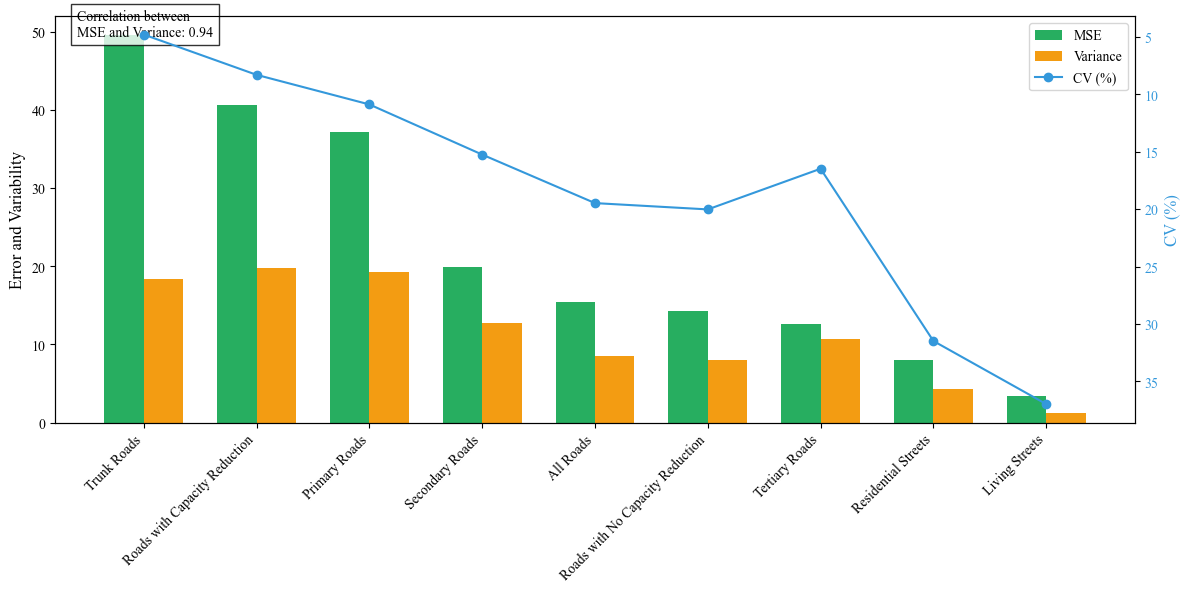

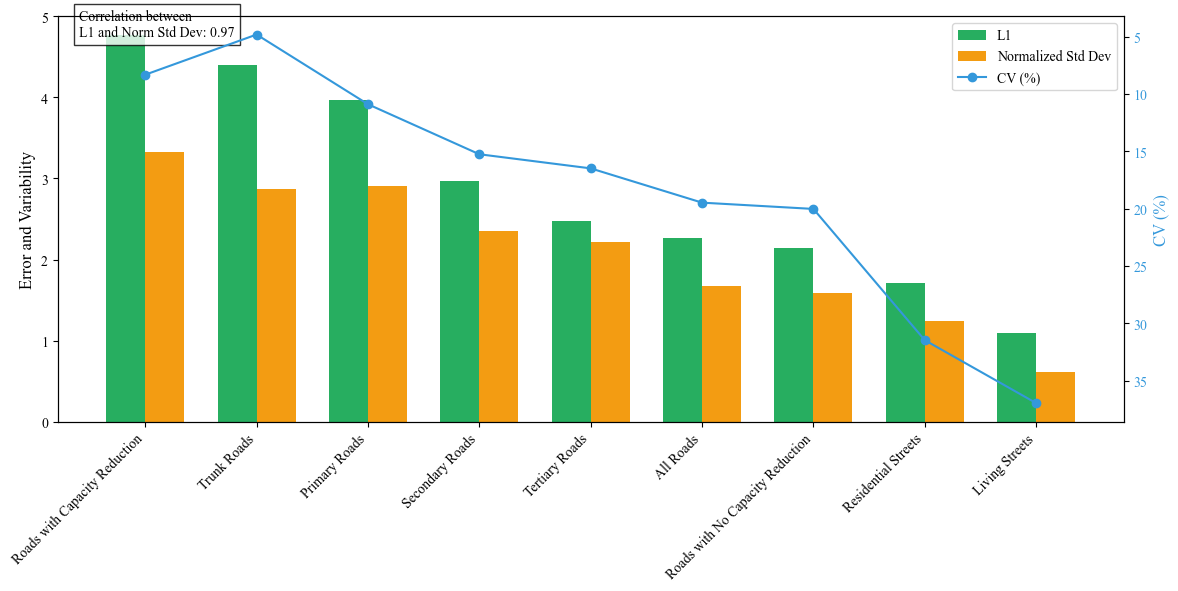

Correlations for MSE vs Variance plot:
Pearson r (MSE vs CV) = -0.36
Pearson r (Variance vs CV) = -0.30
Pearson r (MSE vs Variance) = 0.94

Correlations for L1 vs Normalized Std Dev plot:
Pearson r (L1 vs CV) = -0.37
Pearson r (Norm Std Dev vs CV) = -0.34
Pearson r (L1 vs Norm Std Dev) = 0.97


In [48]:
def create_error_ratio_plots(metrics_by_type):
    """
    Create two separate plots: one for MSE vs Variance and one for L1 vs Normalized Std Dev.
    CV axis is inverted (0 at top). Bars sorted by error metrics.
    """
    plt.rcParams["font.family"] = "Times New Roman"
    
    # Define selected road types
    selected_types = [
        'All Roads',
        'Trunk Roads',
        'Primary Roads',
        'Secondary Roads',
        'Tertiary Roads',
        'Residential Streets',
        'Living Streets',
        'Roads with Capacity Reduction',
        'Roads with No Capacity Reduction'
    ]
    
    # Get and sort data
    mse_values = [metrics_by_type[rt]['mse'] for rt in selected_types]
    variance_values = [metrics_by_type[rt]['variance'] for rt in selected_types]
    cv_values = [metrics_by_type[rt]['cv_percent'] for rt in selected_types]
    l1_values = [metrics_by_type[rt]['l1'] for rt in selected_types]
    std_dev_norm_values = [metrics_by_type[rt]['std_dev_normalized'] for rt in selected_types]
    
    # Sort by MSE for first plot
    sorted_indices_mse = np.argsort(mse_values)[::-1]
    selected_types_mse = [selected_types[i] for i in sorted_indices_mse]
    mse_values = [mse_values[i] for i in sorted_indices_mse]
    variance_values = [variance_values[i] for i in sorted_indices_mse]
    cv_values_mse = [cv_values[i] for i in sorted_indices_mse]
    
    # Sort by L1 for second plot
    sorted_indices_l1 = np.argsort(l1_values)[::-1]
    selected_types_l1 = [selected_types[i] for i in sorted_indices_l1]
    l1_values = [l1_values[i] for i in sorted_indices_l1]
    std_dev_norm_values = [std_dev_norm_values[i] for i in sorted_indices_l1]
    cv_values_l1 = [cv_values[i] for i in sorted_indices_l1]
    
    x = np.arange(len(selected_types))
    bar_width = 0.35
    
    # Plot 1: MSE vs Variance
    fig1, ax1 = plt.subplots(figsize=(12, 6))
    
    bars1 = ax1.bar(x - bar_width/2, mse_values, bar_width, 
                    label='MSE', color='#27ae60')
    bars2 = ax1.bar(x + bar_width/2, variance_values, bar_width, 
                    label='Variance', color='#f39c12')
    
    ax1.set_ylabel('Error and Variability', fontsize=12)
    ax1.set_xticks(x)
    ax1.set_xticklabels(selected_types_mse, rotation=45, ha='right')
    
    # Add correlation annotation
    pearson_mse_var = stats.pearsonr(mse_values, variance_values)[0]
    ax1.text(0.02, 0.95, f'Correlation between\nMSE and Variance: {pearson_mse_var:.2f}', 
             transform=ax1.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
    
    # Secondary y-axis for CV (inverted)
    ax2 = ax1.twinx()
    line1 = ax2.plot(x, cv_values_mse, 'o-', color='#3498db', label='CV (%)')
    ax2.set_ylabel('CV (%)', color='#3498db', fontsize=12)
    ax2.tick_params(axis='y', labelcolor='#3498db')
    ax2.invert_yaxis()
    
    # Combined legend for first plot
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    plt.tight_layout()
    plt.savefig("mse_variance_comparison.png", bbox_inches='tight', dpi=300)
    plt.show()
    
    # Plot 2: L1 vs Normalized Std Dev
    fig2, ax3 = plt.subplots(figsize=(12, 6))
    
    bars3 = ax3.bar(x - bar_width/2, l1_values, bar_width, 
                    label='L1', color='#27ae60')
    bars4 = ax3.bar(x + bar_width/2, std_dev_norm_values, bar_width, 
                    label='Normalized Std Dev', color='#f39c12')
    
    ax3.set_ylabel('Error and Variability', fontsize=12)
    ax3.set_xticks(x)
    ax3.set_xticklabels(selected_types_l1, rotation=45, ha='right')
    
    # Add correlation annotation
    pearson_l1_std = stats.pearsonr(l1_values, std_dev_norm_values)[0]
    ax3.text(0.02, 0.95, f'Correlation between\nL1 and Norm Std Dev: {pearson_l1_std:.2f}', 
             transform=ax3.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
    
    # Secondary y-axis for CV (inverted)
    ax4 = ax3.twinx()
    line2 = ax4.plot(x, cv_values_l1, 'o-', color='#3498db', label='CV (%)')
    ax4.set_ylabel('CV (%)', color='#3498db', fontsize=12)
    ax4.tick_params(axis='y', labelcolor='#3498db')
    ax4.invert_yaxis()
    
    # Combined legend for second plot
    lines3, labels3 = ax3.get_legend_handles_labels()
    lines4, labels4 = ax4.get_legend_handles_labels()
    ax3.legend(lines3 + lines4, labels3 + labels4, loc='upper right')
    
    plt.tight_layout()
    plt.savefig("l1_stddev_comparison.png", bbox_inches='tight', dpi=300)
    plt.show()
    
    # Calculate and print correlations
    pearson_mse_cv = stats.pearsonr(cv_values, mse_values)[0]
    pearson_var_cv = stats.pearsonr(cv_values, variance_values)[0]
    pearson_l1_cv = stats.pearsonr(cv_values, l1_values)[0]
    pearson_std_cv = stats.pearsonr(cv_values, std_dev_norm_values)[0]
    
    print(f"Correlations for MSE vs Variance plot:")
    print(f"Pearson r (MSE vs CV) = {pearson_mse_cv:.2f}")
    print(f"Pearson r (Variance vs CV) = {pearson_var_cv:.2f}")
    print(f"Pearson r (MSE vs Variance) = {pearson_mse_var:.2f}")
    print(f"\nCorrelations for L1 vs Normalized Std Dev plot:")
    print(f"Pearson r (L1 vs CV) = {pearson_l1_cv:.2f}")
    print(f"Pearson r (Norm Std Dev vs CV) = {pearson_std_cv:.2f}")
    print(f"Pearson r (L1 vs Norm Std Dev) = {pearson_l1_std:.2f}")

# Create the plots
create_error_ratio_plots(metrics_by_type)

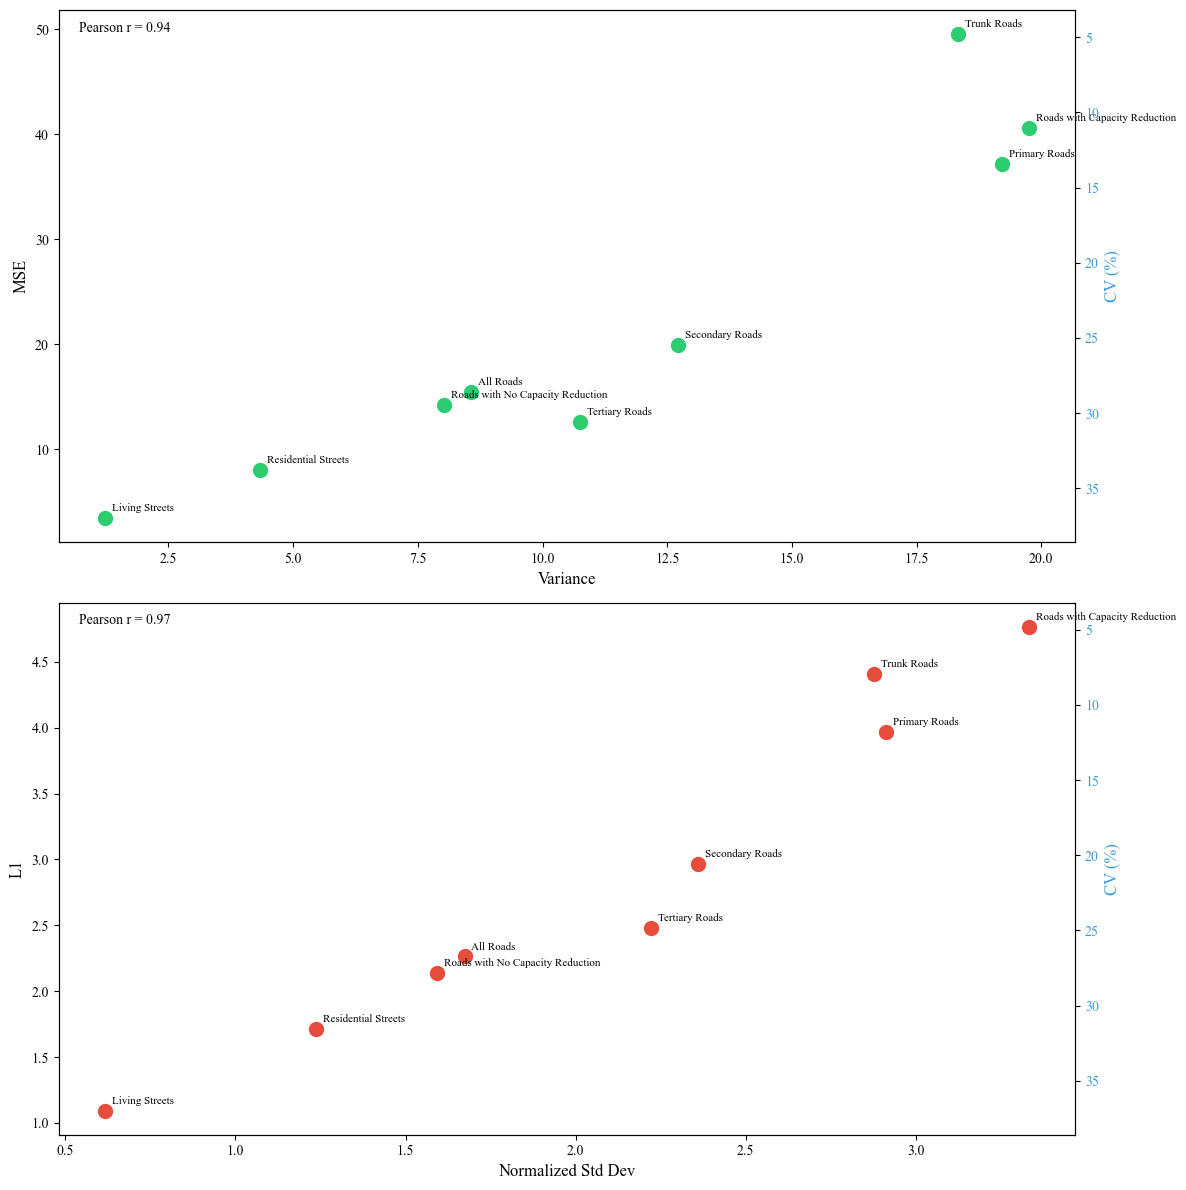

In [24]:
def create_error_vs_variability_scatterplots(metrics_by_type):
    """
    Create two scatter plots:
    1. MSE vs Variance
    2. L1 vs Normalized Std Dev
    With CV on secondary axis
    """
    plt.rcParams["font.family"] = "Times New Roman"
    
    # Define selected road types
    selected_types = [
        'All Roads',
        'Trunk Roads',
        'Primary Roads',
        'Secondary Roads',
        'Tertiary Roads',
        'Residential Streets',
        'Living Streets',
        'Roads with Capacity Reduction',
        'Roads with No Capacity Reduction'
    ]
    
    # Create two subplots
    fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(12, 12))
    
    # Get data
    mse_values = [metrics_by_type[rt]['mse'] for rt in selected_types]
    variance_values = [metrics_by_type[rt]['variance'] for rt in selected_types]
    l1_values = [metrics_by_type[rt]['l1'] for rt in selected_types]
    std_dev_norm_values = [metrics_by_type[rt]['std_dev_normalized'] for rt in selected_types]
    cv_values = [metrics_by_type[rt]['cv_percent'] for rt in selected_types]
    
    # Plot 1: MSE vs Variance
    ax1.scatter(variance_values, mse_values, color='#2ecc71', s=100)
    # Add road type labels to points
    for i, txt in enumerate(selected_types):
        ax1.annotate(txt, (variance_values[i], mse_values[i]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    ax1.set_xlabel('Variance', fontsize=12)
    ax1.set_ylabel('MSE', fontsize=12)
    
    # Secondary y-axis for CV in first plot (inverted)
    ax2 = ax1.twinx()
    ax2.scatter(variance_values, cv_values, color='#3498db', alpha=0)  # Invisible points to set scale
    ax2.set_ylabel('CV (%)', color='#3498db', fontsize=12)
    ax2.tick_params(axis='y', labelcolor='#3498db')
    ax2.invert_yaxis()  # Invert the CV axis
    
    # Plot 2: L1 vs Normalized Std Dev
    ax3.scatter(std_dev_norm_values, l1_values, color='#e74c3c', s=100)
    # Add road type labels to points
    for i, txt in enumerate(selected_types):
        ax3.annotate(txt, (std_dev_norm_values[i], l1_values[i]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    ax3.set_xlabel('Normalized Std Dev', fontsize=12)
    ax3.set_ylabel('L1', fontsize=12)
    
    # Secondary y-axis for CV in second plot (inverted)
    ax4 = ax3.twinx()
    ax4.scatter(std_dev_norm_values, cv_values, color='#3498db', alpha=0)  # Invisible points to set scale
    ax4.set_ylabel('CV (%)', color='#3498db', fontsize=12)
    ax4.tick_params(axis='y', labelcolor='#3498db')
    ax4.invert_yaxis()  # Invert the CV axis
    
    # Calculate correlations
    pearson_mse_var = stats.pearsonr(variance_values, mse_values)[0]
    pearson_l1_std = stats.pearsonr(std_dev_norm_values, l1_values)[0]
    
    # Add correlation coefficients
    ax1.text(0.02, 0.98, f'Pearson r = {pearson_mse_var:.2f}', 
             transform=ax1.transAxes, verticalalignment='top')
    ax3.text(0.02, 0.98, f'Pearson r = {pearson_l1_std:.2f}', 
             transform=ax3.transAxes, verticalalignment='top')
    
    plt.tight_layout()
    plt.savefig("error_vs_variability_scatter.png", bbox_inches='tight', dpi=300)
    plt.show()

# Create the plots
create_error_vs_variability_scatterplots(metrics_by_type)

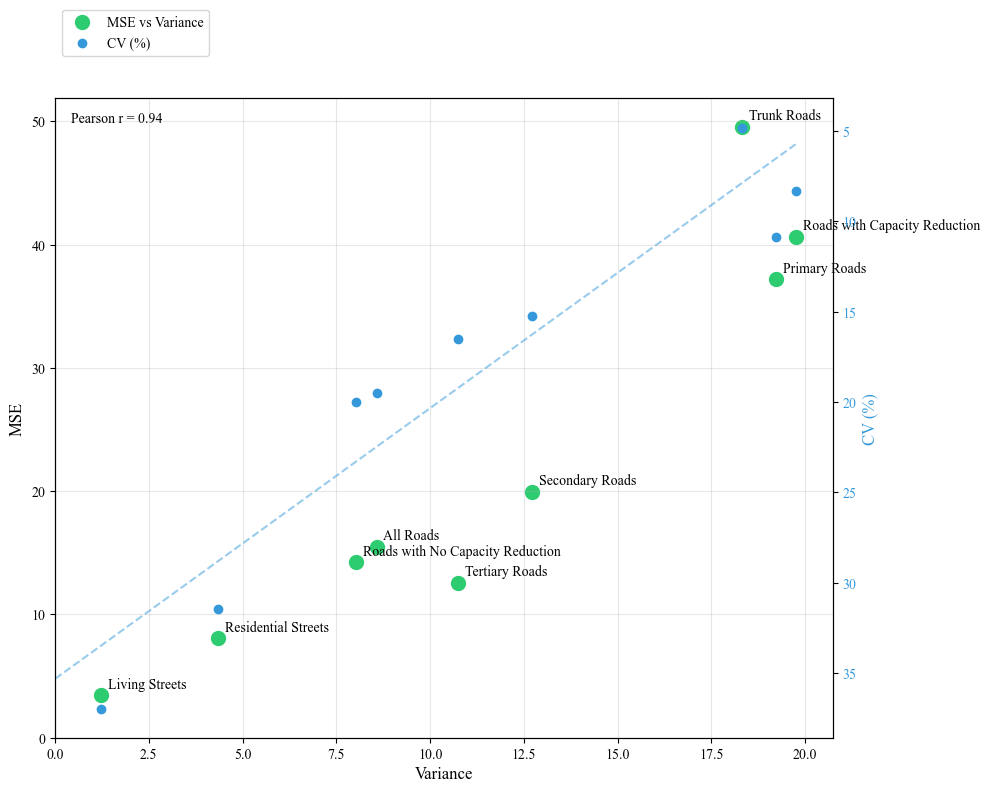

In [26]:
def create_mse_vs_variance_scatterplot(metrics_by_type):
    """
    Create a scatter plot showing MSE vs Variance relationship with CV on secondary axis
    and a linear regression line
    """
    plt.rcParams["font.family"] = "Times New Roman"
    
    # Define selected road types
    selected_types = [
        'All Roads',
        'Trunk Roads',
        'Primary Roads',
        'Secondary Roads',
        'Tertiary Roads',
        'Residential Streets',
        'Living Streets',
        'Roads with Capacity Reduction',
        'Roads with No Capacity Reduction'
    ]
    
    # Create figure
    fig, ax1 = plt.subplots(figsize=(10, 8))
    
    # Get data
    mse_values = [metrics_by_type[rt]['mse'] for rt in selected_types]
    variance_values = [metrics_by_type[rt]['variance'] for rt in selected_types]
    cv_values = [metrics_by_type[rt]['cv_percent'] for rt in selected_types]
    
    # Plot MSE vs Variance
    scatter1 = ax1.scatter(variance_values, mse_values, color='#2ecc71', s=100, label='MSE vs Variance')
    
    # Add road type labels to points
    for i, txt in enumerate(selected_types):
        ax1.annotate(txt, (variance_values[i], mse_values[i]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=10)
    
    # Add linear regression line for CV
    z = np.polyfit(variance_values, cv_values, 1)
    p = np.poly1d(z)
    x_range = np.linspace(0, max(variance_values), 100)
    
    # Secondary y-axis for CV (inverted)
    ax2 = ax1.twinx()
    scatter2 = ax2.scatter(variance_values, cv_values, color='#3498db', label='CV (%)')
    line = ax2.plot(x_range, p(x_range), '--', color='#3498db', alpha=0.5)
    
    ax2.set_ylabel('CV (%)', color='#3498db', fontsize=12)
    ax2.tick_params(axis='y', labelcolor='#3498db')
    ax2.invert_yaxis()  # Invert the CV axis
    
    # Set axes to start at 0 and add regular grid
    ax1.set_xlim(left=0)
    ax1.set_ylim(bottom=0)
    ax1.grid(True, alpha=0.3)
    
    ax1.set_xlabel('Variance', fontsize=12)
    ax1.set_ylabel('MSE', fontsize=12)
    
    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', bbox_to_anchor=(0, 1.15))
    
    # Calculate correlation
    pearson_mse_var = stats.pearsonr(variance_values, mse_values)[0]
    
    # Add correlation coefficient
    ax1.text(0.02, 0.98, f'Pearson r = {pearson_mse_var:.2f}', 
             transform=ax1.transAxes, verticalalignment='top')
    
    # plt.title('MSE vs Variance Relationship', pad=20)
    plt.tight_layout()
    plt.savefig("mse_vs_variance_scatter.png", bbox_inches='tight', dpi=300)
    plt.show()

# Create the plot
create_mse_vs_variance_scatterplot(metrics_by_type)

/tmp/ipykernel_1213599/1764623071.py:45: RuntimeWarning: divide by zero encountered in scalar divide
  cv_scaled = cv_values[i] * (ax1.get_ylim()[1] / ax2.get_ylim()[0])


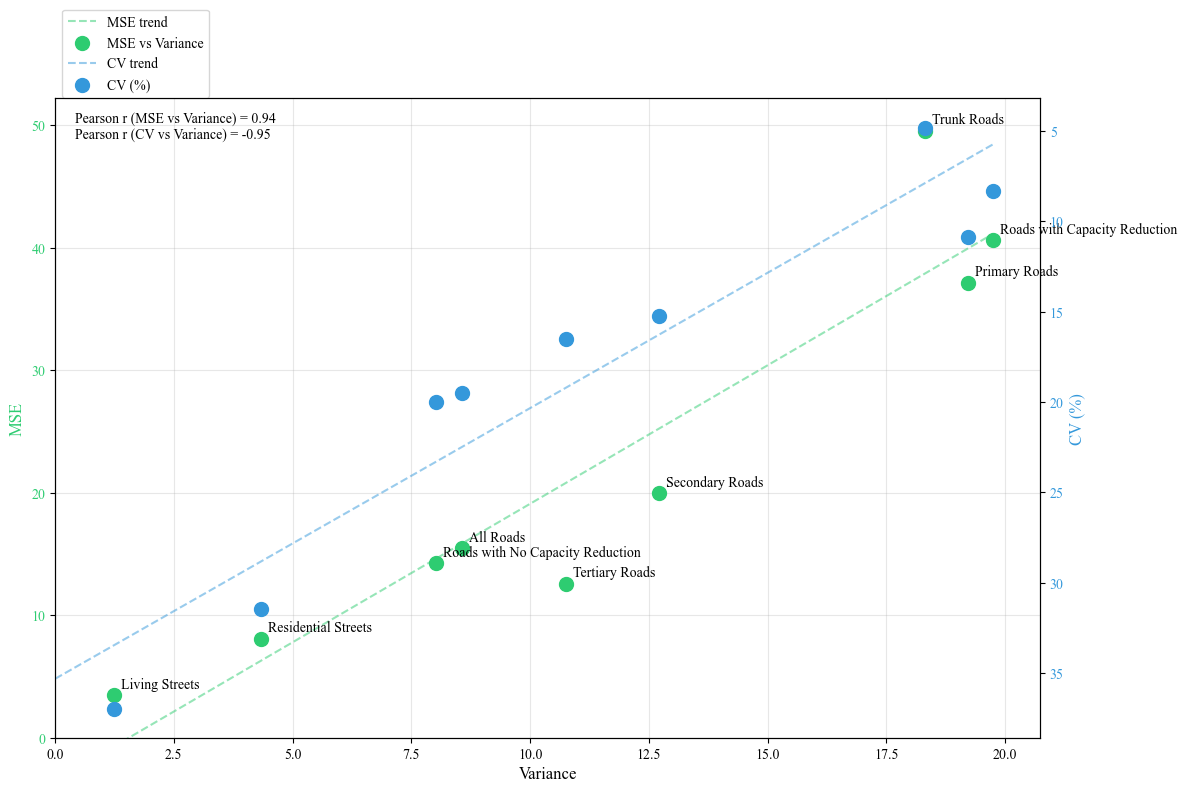

In [38]:
def create_mse_vs_variance_scatterplot(metrics_by_type):
    """
    Create a scatter plot showing MSE vs Variance relationship with CV on secondary axis
    (inverted, 0 at top) and connecting lines between corresponding MSE and CV points
    """
    plt.rcParams["font.family"] = "Times New Roman"
    
    # Define selected road types
    selected_types = [
        'All Roads',
        'Trunk Roads',
        'Primary Roads',
        'Secondary Roads',
        'Tertiary Roads',
        'Residential Streets',
        'Living Streets',
        'Roads with Capacity Reduction',
        'Roads with No Capacity Reduction'
    ]
    
    # Create figure
    fig, ax1 = plt.subplots(figsize=(12, 8))
    
    # Get data
    mse_values = [metrics_by_type[rt]['mse'] for rt in selected_types]
    variance_values = [metrics_by_type[rt]['variance'] for rt in selected_types]
    cv_values = [metrics_by_type[rt]['cv_percent'] for rt in selected_types]
    
    # Add linear regression lines
    # For MSE vs Variance
    z_mse = np.polyfit(variance_values, mse_values, 1)
    p_mse = np.poly1d(z_mse)
    # For CV vs Variance
    z_cv = np.polyfit(variance_values, cv_values, 1)
    p_cv = np.poly1d(z_cv)
    x_range = np.linspace(0, max(variance_values), 100)
    
    # Secondary y-axis for CV (inverted)
    ax2 = ax1.twinx()
    
    # Draw connecting lines first (so they're behind the points)
    for i in range(len(selected_types)):
        # Draw a light gray line connecting corresponding MSE and CV points
        # Convert CV value to MSE scale for proper line drawing
        cv_scaled = cv_values[i] * (ax1.get_ylim()[1] / ax2.get_ylim()[0])
        ax1.plot([variance_values[i], variance_values[i]], 
                [mse_values[i], cv_scaled],
                color='gray', alpha=0.2, linestyle='--', zorder=1)
    
    # Plot trend lines
    line_mse = ax1.plot(x_range, p_mse(x_range), '--', color='#2ecc71', alpha=0.5,
                        label='MSE trend', zorder=2)
    line_cv = ax2.plot(x_range, p_cv(x_range), '--', color='#3498db', alpha=0.5,
                       label='CV trend', zorder=2)
    
    # Plot points
    scatter1 = ax1.scatter(variance_values, mse_values, color='#2ecc71', s=100, 
                          label='MSE vs Variance', zorder=3)
    scatter2 = ax2.scatter(variance_values, cv_values, color='#3498db', s=100,
                          label='CV (%)', zorder=3)
    
    # Add single label for each road type next to the MSE point
    for i, txt in enumerate(selected_types):
        ax1.annotate(txt, (variance_values[i], mse_values[i]), 
                    xytext=(5, 5), textcoords='offset points', 
                    fontsize=10, color='black')
    
    # Set up axes
    ax2.set_ylabel('CV (%)', color='#3498db', fontsize=12)
    ax2.tick_params(axis='y', labelcolor='#3498db')
    ax2.invert_yaxis()  # Invert the CV axis to have 0 at top
    
    ax1.set_xlim(left=0)
    ax1.set_ylim(bottom=0)
    ax1.grid(True, alpha=0.3, zorder=0)
    
    ax1.set_xlabel('Variance', fontsize=12)
    ax1.set_ylabel('MSE', color='#2ecc71', fontsize=12)
    ax1.tick_params(axis='y', labelcolor='#2ecc71')
    
    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, 
              loc='upper left', bbox_to_anchor=(0, 1.15))
    
    # Calculate correlations
    pearson_mse_var = stats.pearsonr(variance_values, mse_values)[0]
    pearson_cv_var = stats.pearsonr(variance_values, cv_values)[0]
    
    # Add correlation coefficients
    ax1.text(0.02, 0.98, 
             f'Pearson r (MSE vs Variance) = {pearson_mse_var:.2f}\n' +
             f'Pearson r (CV vs Variance) = {pearson_cv_var:.2f}', 
             transform=ax1.transAxes, verticalalignment='top')
    
    plt.tight_layout()
    plt.savefig("mse_vs_variance_scatter.png", bbox_inches='tight', dpi=300)
    plt.show()

# Create the plot
create_mse_vs_variance_scatterplot(metrics_by_type)